# Exam Machine Learning with Python

Submitted by : 

Dries Luts (dries-luts@hotmail.com)<br />
Bino Maiheu (binomaiheu@gmail.com)<br />
Marijke Van De Steene (marijkevandesteene@hotmail.com)<br />

This notebook is submitted by the group above for the course exame "Machine Learning with Python", taught by Bart Van Rompaye. Course IPVW-
ICES 2024, **due date**: 2024-07-03 23:59. 

# Changelog

- **2024-06-05** [MV] : Initial version
- **2024-06-06** [BM] : Consolidated structure, imported initial analysis from notebooks 



# Initialisation

## Packages

In [1]:
# -- Importing packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats
import scikitplot as skplt 
import pickle

from pathlib import Path

In [2]:
# -- Import Machine learning libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # for preprocessing & scaling
from sklearn.preprocessing import PolynomialFeatures  # for polynomial features preprocessing
from sklearn.impute import SimpleImputer, KNNImputer   # for missing values imputation
from sklearn.model_selection import train_test_split  # train-test splits
from sklearn.model_selection import StratifiedKFold  # K-fold resampling, stratified
from sklearn.model_selection import GridSearchCV  # Hyperparameter tuning
from sklearn.calibration import CalibratedClassifierCV  # Hyperparameter tuning with calibration
from sklearn.calibration import calibration_curve  # calibration curve plotting
from sklearn.calibration import CalibrationDisplay  # calibration curve plotting
from sklearn.metrics import confusion_matrix  # performance metrics, confusion matrix
from sklearn.metrics import classification_report  # performance matrix classifiaction report
from sklearn.metrics import roc_auc_score  # Area Under Receiver Operating Characteristics
from sklearn.metrics import roc_curve  # ROC
from sklearn.metrics import RocCurveDisplay  # ROC plotting
from sklearn.metrics import accuracy_score  # performance metric accuracy (0/1) score
from sklearn.metrics import precision_score  # performance metric
from sklearn.linear_model import LogisticRegression  # Logistic regression modelling
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.ensemble import GradientBoostingClassifier  # GBM for classification
from sklearn import svm
from sklearn.utils import resample  # Resampling
from imblearn.over_sampling import SMOTE  # Synthetic upsampling

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold


In [3]:
# -- Import Defined functions
import common_used_functions as cuf

## Notebook setup

In [4]:
# -- Setting plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [5]:
# -- Jupyter magic command to show plots inline immediately
%matplotlib inline

In [6]:
# -- Setting seed
seed = 43
np.random.seed(seed)

In [7]:
# -- pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importing datafiles

In [8]:
# -- Loading the house price dataset
data_file_path = Path('input')  # Set to the path of folder where you can find 'train_V2.csv' and 'score.csv'

train_filename = data_file_path / 'train_V2.csv'
score_filename = data_file_path / 'score.csv'
dict_filename = data_file_path / 'dictionary.csv'

# -- Training & scoring data
train_V2 = pd.read_csv(train_filename)
score = pd.read_csv(score_filename)

# -- We load the dictionare as a dict
#    Note that small edits were made to the original file 
#    - tenure_yrs occurred twice, this was corrected
#    - income_am did not occur, was added...
dictionary = pd.read_csv(dict_filename, sep=';', header=None).set_index(0).to_dict(orient="dict")[1]

# -- Some feedback 
print('Training set shape: {}' .format(train_V2.shape))
print('Score set shape: {}' .format(score.shape))

Training set shape: (5000, 53)
Score set shape: (500, 50)


In [9]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,M,0.000000,0.0,0.0,0.0,0.467768,0.98334,NaN,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,0.232375,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,V,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,V,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


We first analyse some high level stuff regarding the loaded data

In [10]:
# -- print list of features
print('Training set features : ')
print(train_V2.columns)

Training set features : 
Index(['income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc',
       'crd_lim_rec', 'credit_use_ic', 'gluten_ic', 'lactose_ic',
       'insurance_ic', 'spa_ic', 'empl_ic', 'cab_requests', 'married_cd',
       'bar_no', 'sport_ic', 'neighbor_income', 'age', 'marketing_permit',
       'urban_ic', 'dining_ic', 'presidential', 'client_segment', 'sect_empl',
       'prev_stay', 'prev_all_in_stay', 'divorce', 'fam_adult_size',
       'children_no', 'tenure_mts', 'tenure_yrs', 'company_ic', 'claims_no',
       'claims_am', 'nights_booked', 'gender', 'shop_am', 'shop_use',
       'retired', 'gold_status', 'score1_pos', 'score1_neg', 'score2_pos',
       'score2_neg', 'score3_pos', 'score3_neg', 'score4_pos', 'score4_neg',
       'score5_pos', 'score5_neg', 'outcome_profit', 'outcome_damage_inc',
       'outcome_damage_amount'],
      dtype='object')


In [11]:
# -- compare the feaures in the training & score sets
print("Features in the training set but not in the scoring set (target variables) : ")
set(train_V2.columns).difference(set(score.columns))

Features in the training set but not in the scoring set (target variables) : 


{'outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'}

In [12]:
# -- Adding an index to the 
train_V2.insert(0, 'Id', range(0, 0 + len(train_V2)))
if 'Id' in train_V2.columns:
    train_V2 = train_V2.set_index('Id')

score.insert(0, 'Id', range(0, 0 + len(score)))
if 'Id' in score.columns:
    score = score.set_index('Id')

In [13]:
# -- Print some info
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  sport_ic 

# Dataset preparation

Ok, now that we have our data loaded, lets dive into the anlysis.  In this section we shall check for consistency, handle missing values, outliers etc... We first start  with extracting categorical and numerical features

## An important consideration in DATA PREPARATION: the same actions are needed for score

## Extraction of categorical and numerical features

It's not clear immediately what the categorical and numerical features are in the dataset, this is important for later on (e.g. imputation of missing values), so we spend a little time analysing this. 


Here we aim to get a list of feature names (i.e. column names) one with categorical features, one with numerical features

In [14]:
# -- test the number of unique values in the dataframe
train_nunique = train_V2.nunique()
train_nunique

income_am                2109
profit_last_am           1452
profit_am                2139
damage_am                 616
damage_inc                 11
crd_lim_rec                41
credit_use_ic               2
gluten_ic                   2
lactose_ic                  2
insurance_ic                2
spa_ic                      2
empl_ic                     2
cab_requests               17
married_cd                  2
bar_no                     47
sport_ic                    2
neighbor_income          3042
age                        72
marketing_permit            2
urban_ic                    2
dining_ic                   2
presidential                2
client_segment              6
sect_empl                   6
prev_stay                   2
prev_all_in_stay            2
divorce                     2
fam_adult_size              4
children_no                 7
tenure_mts                586
tenure_yrs                 58
company_ic                  2
claims_no                  10
claims_am 

In [15]:
# train_nunique[ train_nunique == 2 ]

We see quite some variables with only 2 unique values, and from looking at the dictionary, those likely will be binary features : true/false. 

Additionally, we see that the features `client_segment` as well as `sect_empl` also only contain 6 unique values and from the dictionary (client and employment sectors), it is safe to assume that those features are also categorical. Some additional features also contain a limited amount of unique values, however, judging from the dictionary those should not be considered categorical : 
- `fam_adult_size`: number of adults in family
- `children_no` : number of children

So, in summary we can create the following classification for the features (categorical/numerical):

In [16]:
# the categorical input features are those with 2 unique values, as well as client_segment and sect_empl, but not the ones which start with outcome, those are target features
categorical_input_features = [ 'client_segment', 'sect_empl', *train_nunique[ (train_nunique == 2) & ~train_nunique.index.str.startswith('outcome_') ].index.to_list() ]

# the numerical input features the other ones but not the ones which start with outcome, those are target features
numerical_input_features = train_V2.columns[ ~train_V2.columns.isin(categorical_input_features) & ~train_V2.columns.str.startswith('outcome_')].to_list()

# these are the target features in the dataframe
target_features = ['outcome_profit', 'outcome_damage_amount', 'outcome_damage_inc']

### Categorical input features

These are the resulting categorical input features :

In [17]:
for ft in categorical_input_features:
    print(f"- {ft} : {dictionary[ft]}")

- client_segment : segment of client
- sect_empl : employment sector
- credit_use_ic : previously used hotel credit
- gluten_ic : allergic to gluten
- lactose_ic : lactose intolerant
- insurance_ic : use of hotel insurance
- spa_ic : spa user
- empl_ic : employee of chain
- married_cd : marital status
- sport_ic : user of sports facilities
- marketing_permit : marketing contact allowed
- urban_ic : from urban region (vs rural)
- dining_ic : use of in-hotel restaurants
- presidential : previous use of presidential suite
- prev_stay : previous stay at hotel indicator
- prev_all_in_stay : previous stay at hotel with all-in formula indicator
- divorce : indicator divorce
- company_ic : indicator company card
- gender : gender code
- shop_use : used hotel shop court
- retired : retired indicator
- gold_status : gold client profile


### Numerical input features
These are the resulting numerical features 

In [18]:
for ft in numerical_input_features:
    print(f"- {ft} : {dictionary[ft]}")

- income_am : income (added)
- profit_last_am : profit across second last visit
- profit_am : total profit across visits  (excluding last visit)
- damage_am : total amount of damages  (excluding last visit)
- damage_inc : number of damage incidents  (excluding last visit)
- crd_lim_rec : Recommended limit hotel credit 
- cab_requests : number of cab requests
- bar_no : number of hotel bar visits
- neighbor_income : Mean taxable income of neighborhood
- age : age
- fam_adult_size : number of adults in family
- children_no : number of known children
- tenure_mts : months as client in months
- tenure_yrs : years as client in years
- claims_no : number of claims against hotel
- claims_am : compensations payed after claims
- nights_booked : total nights booked at chain
- shop_am : amount spent in shop
- score1_pos : positivity' score, given by staff, as quantile, from hotel 1
- score1_neg : negativity' score, given by staff, as quantile, from hotel 1
- score2_pos : positivity' score, given 

### Target features
These are the target features (initially... in the further analysis, this will be refined)

In [19]:
for ft in target_features:
    print(f"- {ft} : {dictionary[ft]}")

- outcome_profit : profit of last visit
- outcome_damage_amount : damage amount after last visit
- outcome_damage_inc : damage incident in last visit


### Discussion on memory consumption

Ideally, to reduce the **memory footprint** of this data, we reallocate the categorical variables to a smaller integer, or even a boolean. Currently the variables are in memory as 64 bit floats which is way to large. At the moment we leave things as they are & come back to this if time permits. Note that we will make some alterations onwards as some features, like gender are "objects", i.e. strings. 

## Dataset consistency tests

### Feature types

Some observations in the output of `train_V2.info()` above here: 

- all the variables seem to be numeric (encoded as float64), except for:
- `gender` : object contains 'M' or 'V', we will replace those with 0 and 1 for consistency with the other variables
- `married_cd` : appears to be a boolean, so clearly this is categorical

Let's first look at the feature types. 

In [20]:
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  sport_ic 

In [21]:
score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   income_am         496 non-null    float64
 1   profit_last_am    496 non-null    float64
 2   profit_am         496 non-null    float64
 3   damage_am         497 non-null    float64
 4   damage_inc        496 non-null    float64
 5   crd_lim_rec       496 non-null    float64
 6   credit_use_ic     496 non-null    float64
 7   gluten_ic         496 non-null    float64
 8   lactose_ic        496 non-null    float64
 9   insurance_ic      496 non-null    float64
 10  spa_ic            498 non-null    float64
 11  empl_ic           500 non-null    float64
 12  cab_requests      495 non-null    float64
 13  married_cd        500 non-null    bool   
 14  bar_no            496 non-null    float64
 15  sport_ic          496 non-null    float64
 16  neighbor_income   479 non-null    float64
 17  ag

In [22]:
# -- re-assign the gender to 0 or 1 
train_V2['gender'] = train_V2['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1
score['gender'] = score['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1

### Histogram analysis of the score variables

When looking a bit more closely to the distribution of the score variables, we noticed that score5_neg did not conform to the rest of the data. In the introductory document to the exam, it was stated that these score variables represented quantiles. Likely in case of hotel 5, this is still a raw score which has not been converted to a quantile yet.

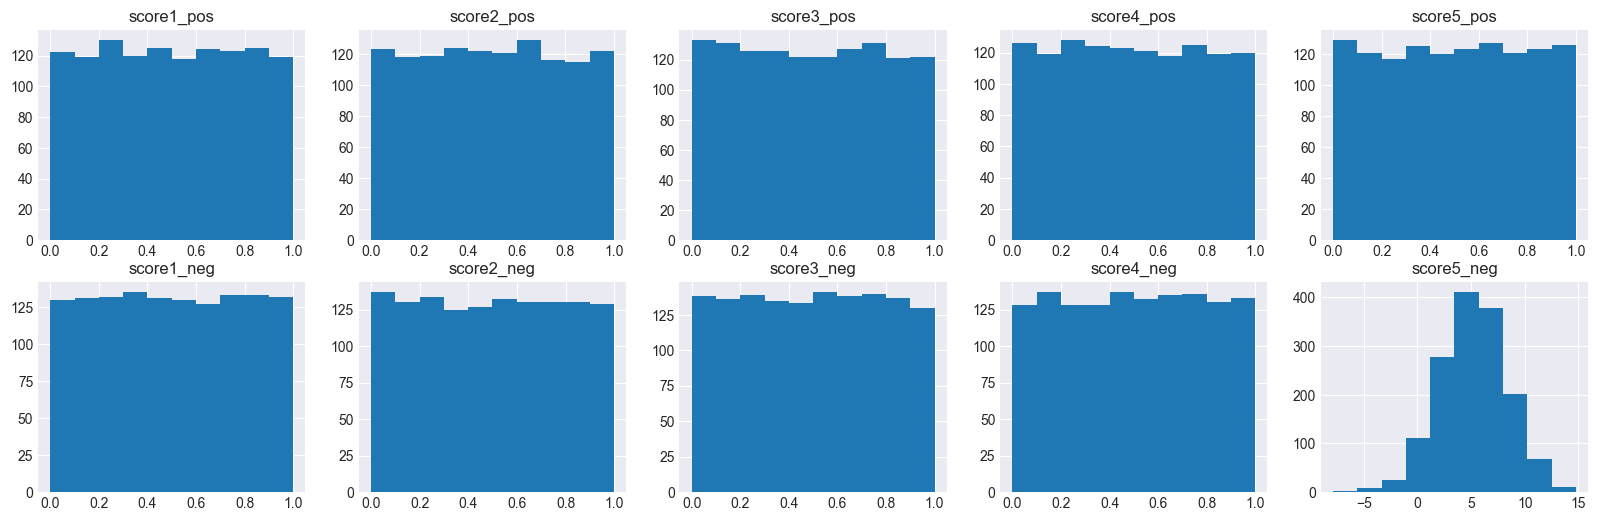

In [23]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

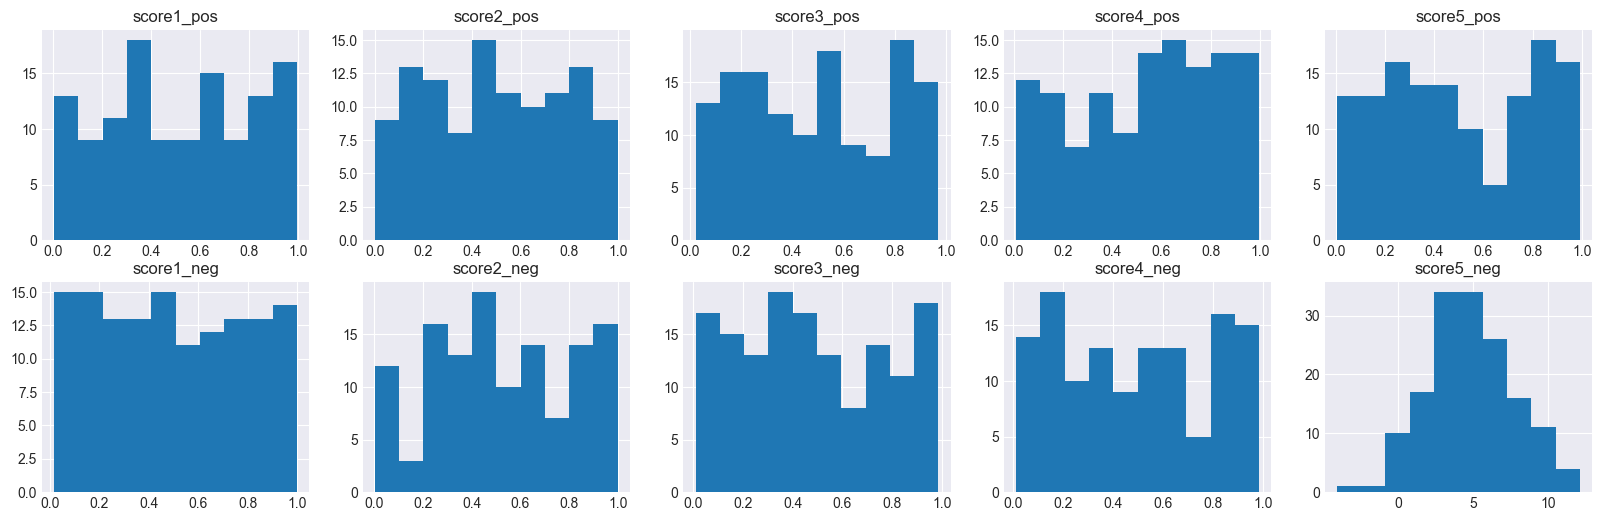

In [24]:
# histogram score
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    score[f"score{k+1}_pos"].hist(ax=axs[0][k])
    score[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

Let's in case of hotel5 convert this score to a quantile value. To do this, we have to be a bit carefull. An easy way to handle this would be to calculate the percentile rank for the score, e.g. : 

```python
train_V2["score5_neg_uniform"]  = train_V2["score5_neg"].rank(method='max', pct=True)
```

However, it would be rather difficult to apply this consistently on the independent score dataset later on. So, as an alternative we will get the quantiles from the cumulative distribution function, we can do this via the emprical cdf or rescale the distribution to zero mean and unit variance, assuming it's shape to be - let's say - Gaussian and compute the quantiles from that cdf, keeping things simple, we opted to calculate the z-score, assume the distirbution is roughly Gaussian(without rigorously checking, as this probably won't affect the result significantly) in the following way, using `scipy.stats.norm.cdf`. For discussion see: https://github.com/Marijkevandesteene/MachineLearning/issues/22

In [25]:
train_V2["score5_neg_uniform"] = ( train_V2["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
train_V2["score5_neg_uniform"] = stats.norm.cdf(train_V2["score5_neg_uniform"])
score["score5_neg_uniform"] = ( score["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
score["score5_neg_uniform"] = stats.norm.cdf(score["score5_neg_uniform"])

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

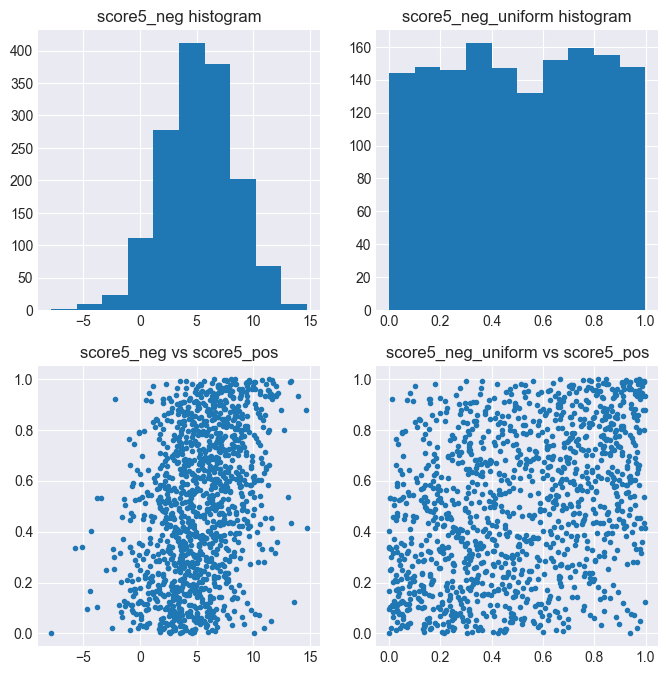

In [26]:
# -- a small check
fig, axs = plt.subplots(2,2, figsize=(8,8))
train_V2["score5_neg"].hist(ax=axs[0][0])
train_V2["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

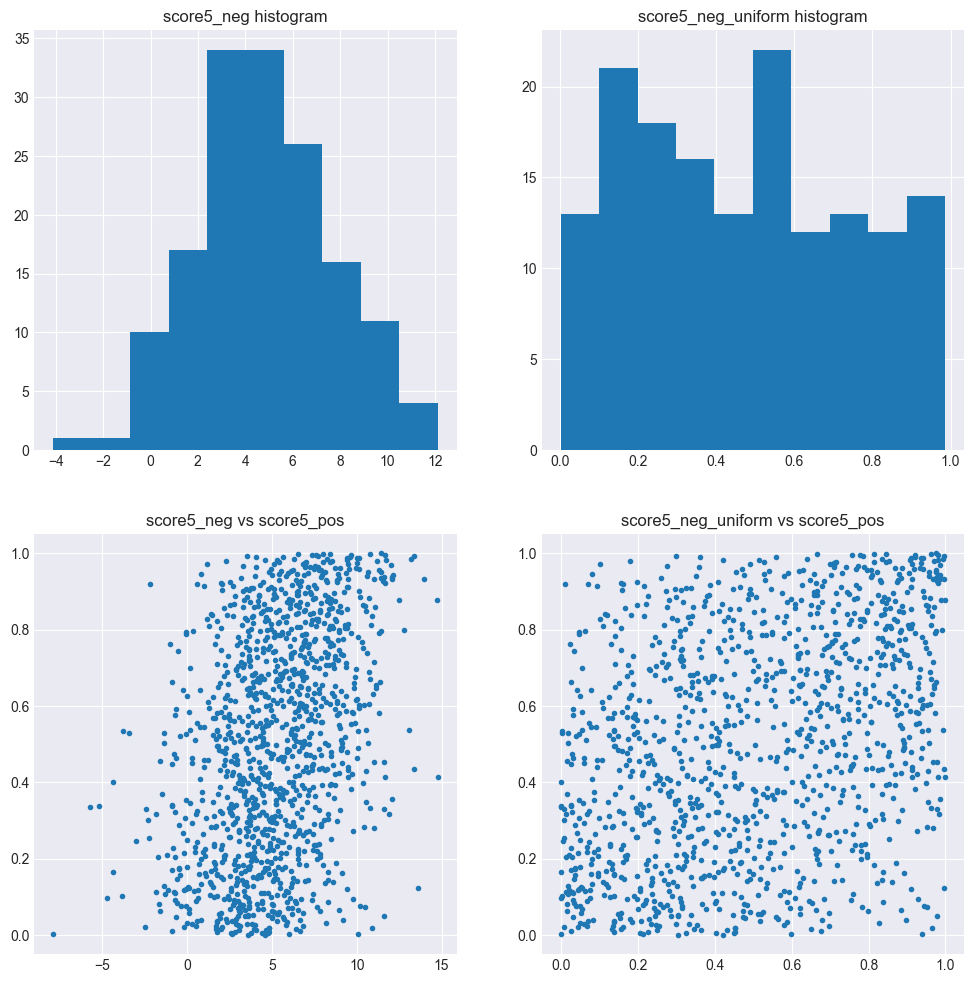

In [27]:
# -- a similar check on score data
fig, axs = plt.subplots(2,2, figsize=(12,12))
score["score5_neg"].hist(ax=axs[0][0])
score["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

In [28]:
#  -- and now replace the variable in the dataset for training data and for score
train_V2['score5_neg'] = train_V2['score5_neg_uniform']
train_V2.drop(columns=['score5_neg_uniform'], inplace=True)
score['score5_neg'] = score['score5_neg_uniform']
score.drop(columns=['score5_neg_uniform'], inplace=True)

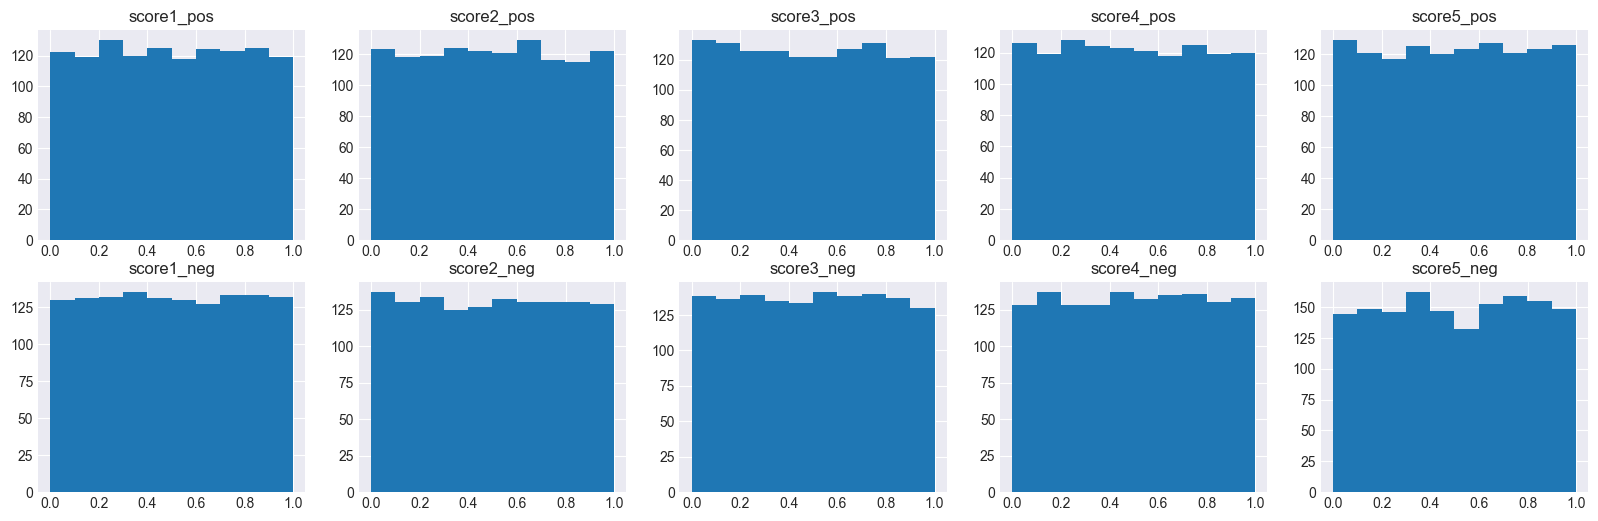

In [29]:
# -- make a small plot to check the resutls:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

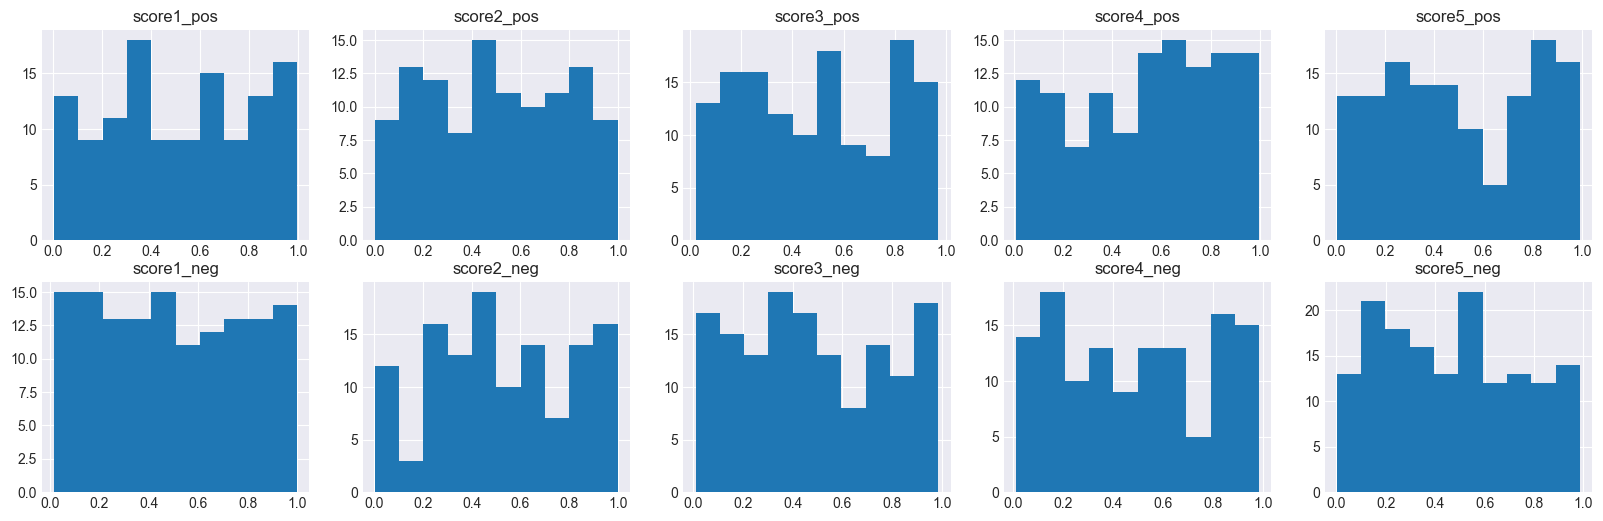

In [30]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    score[f"score{k+1}_pos"].hist(ax=axs[0][k])
    score[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

### Consistency between damage incurred and damage amount

In [31]:
print(f"Max damage amount when no damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 0, 'outcome_damage_amount'].max()}")
print(f"Min damage amount when damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 1, 'outcome_damage_amount'].min()}")

Max damage amount when no damage is incurred : 0.0
Min damage amount when damage is incurred : 0.0


Ha, so there are cases for which there is damage incurred, but the amount of the damage is 0 ... interesting

## Handling of  missing data


### Methodology and TODO's 

1. Getting missing values descending per feature
2. Verwerken van de scores
3. Find instances with missing observations (% of missing for a lot of features is equal > it appears these values for these featues are missing for the same instances)

### General analysis

In [32]:
# Getting an idea about total missing values
total_missings = train_V2.isnull().sum().sort_values(ascending=False)  # total missng values, sorted
print("Top 20 of most missing features : ")
total_missings.head(20)  # Show top 20 most missing features

Top 20 of most missing features : 


score2_pos         3791
score4_pos         3777
score1_pos         3775
score5_pos         3768
score3_pos         3739
score2_neg         3696
score1_neg         3686
score4_neg         3676
score3_neg         3633
score5_neg         3507
tenure_yrs          392
tenure_mts          392
neighbor_income     239
shop_use             88
presidential         88
cab_requests         88
dining_ic            88
company_ic           53
claims_no            53
income_am            53
dtype: int64

<Axes: title={'center': 'Number of missing values per feature'}>

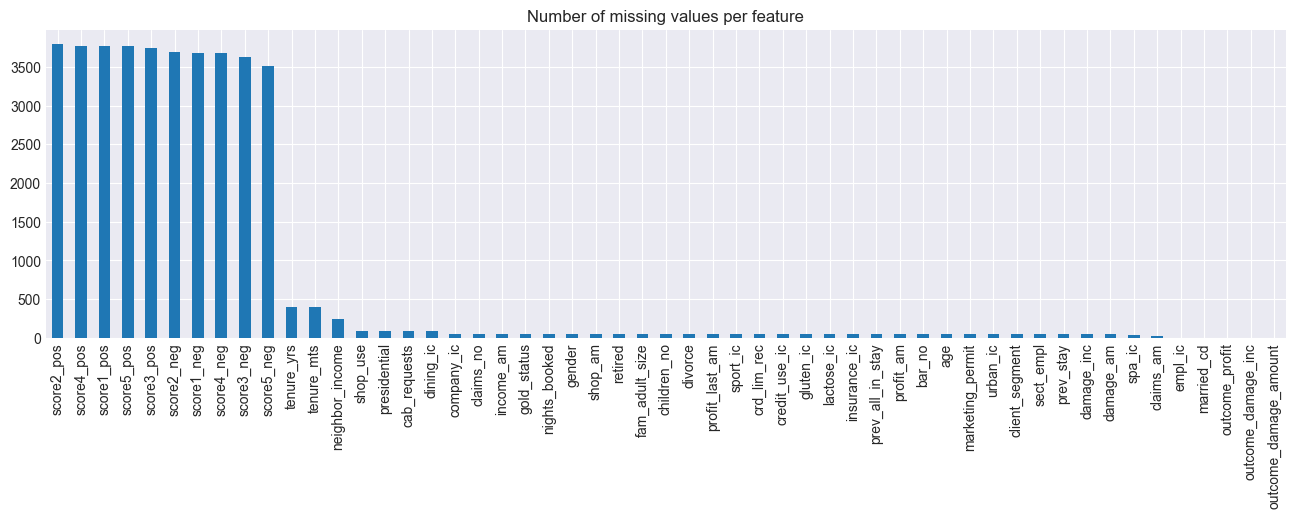

In [33]:
total_missings.plot(kind='bar', figsize=(16,4), title="Number of missing values per feature")

In [34]:
# Getting an idea about percentage missing values
pct_missings = train_V2.isnull().mean().sort_values(ascending=False)  # average (%) missng values, sorted
#pct_missings.head(20)  # Show top 20 most missing features

<Axes: ylabel='pct. missing [%]'>

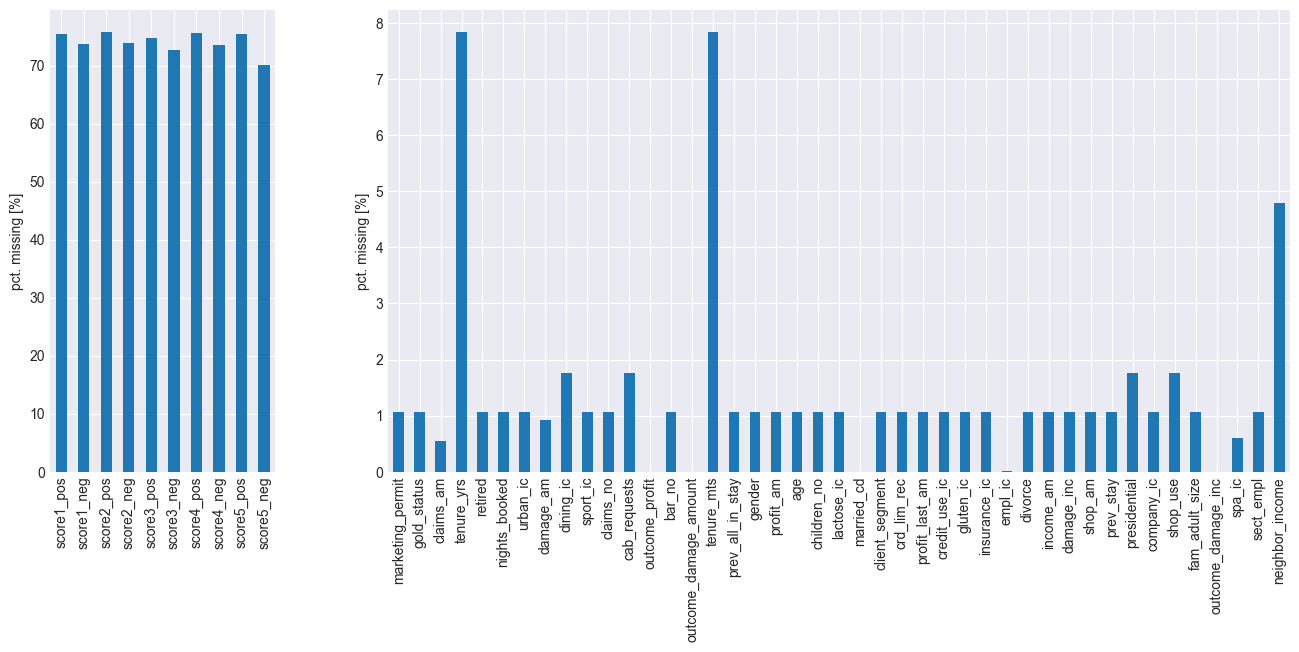

In [35]:
score_vars = [ f"score{i+1}_{xx}" for i in range(5) for xx in ("pos", "neg") ]
other_vars = list(set(train_V2.columns).difference(score_vars))

fig, axs = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [1, 4]})

axs[0].set_ylabel('pct. missing [%]')
axs[1].set_ylabel('pct. missing [%]')

pct_missings[score_vars].multiply(100.).plot(kind='bar', ax=axs[0])
pct_missings[other_vars].multiply(100.).plot(kind='bar', ax=axs[1])

Some conclusions :
- no missing values in the outcomes
- a lot of missing values in the scores given by the hotels (> 70% of the data), however despite the large quantity of missing data, it doesn't seem a good idea to throw away this data as the score given by other hotels in the chain may be a very relevant predictor, so we decide to keep these features and treat the missing values (which in its own right may be relevant information as well). 
- tenure_mts does have almost 10% missing --> perhaps we should not just drop it, but re-use the years !!
- it's striking that a large number of features report the same amount of missing values, so these are probably a set of rows which we can drop

### Treatment of the score values

The imputation of the score values is somewhat tricky. There is potentially a lot of information encoded in there, but also > 70 % of missing values. First of all we do not know from the dataset what hotels correspond to 1, 2, ... 5 also we do not know from the description that hotel1 from the training set corresponds to hotel1 in the score set. By aggregating the scores (.e.g. calculating a mean over the hotels for both the positivity and negativity scores, we can already get rid of a lot of missing values, however the downside is that the information on what hotel did give the score is lost then). Still this may be a good way forward as we don't know for sure whether the hotels in the training & score set correspond (though it's probably safe to assume so). One caveat with this approach is that we would be averaging quantile values, which may not be entirely consistent so it would probably be better to average the original scores, but then we would have to make assumptions on the underlying distribution of these original scores. For a discussion we refer to : https://github.com/Marijkevandesteene/MachineLearning/issues/8

In [36]:
train_V2["avg_score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
train_V2["avg_score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].mean(axis=1)

score["avg_score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
score["avg_score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].mean(axis=1)

In [37]:
train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].head()

,score1_pos,score2_pos,score3_pos,score4_pos,score5_pos
Id,,,,,
0,0.467768,NaN,NaN,0.838147,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,0.232375,NaN,NaN,0.101955
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.330503,0.490486,NaN


Text(0.5, 1.0, 'avg_score_pos')

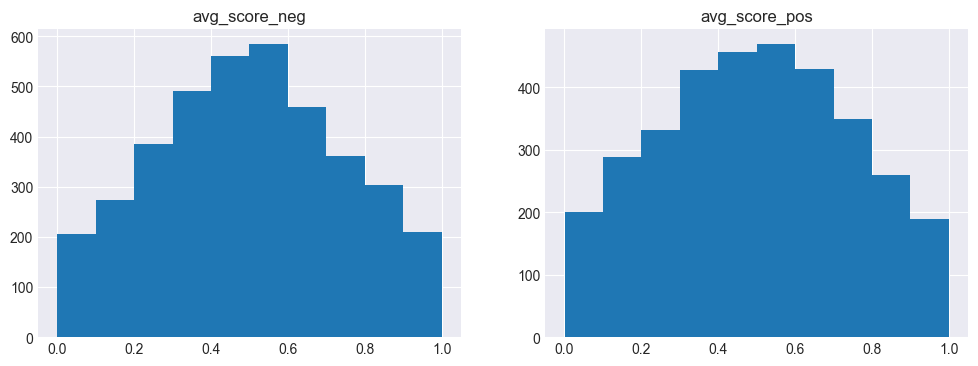

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
train_V2["avg_score_neg"].hist(ax=axs[0])
train_V2["avg_score_pos"].hist(ax=axs[1])
axs[0].set_title("avg_score_neg")
axs[1].set_title("avg_score_pos")

Text(0.5, 1.0, 'avg_score_pos')

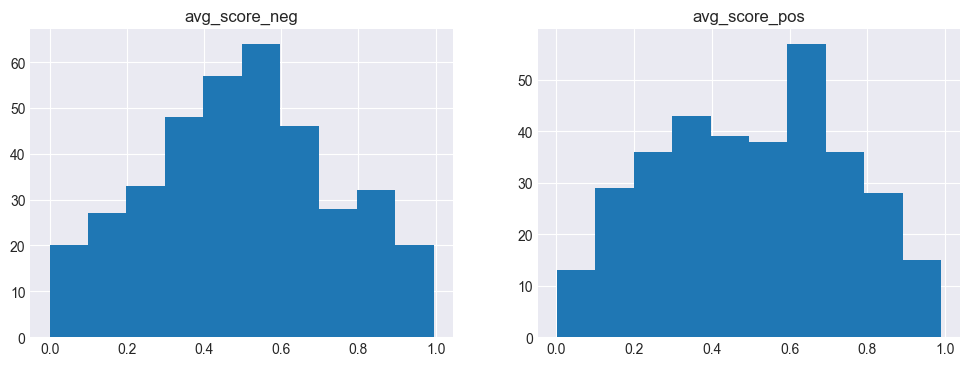

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
score["avg_score_neg"].hist(ax=axs[0])
score["avg_score_pos"].hist(ax=axs[1])
axs[0].set_title("avg_score_neg")
axs[1].set_title("avg_score_pos")

In [40]:
# missing percentages when computing the mean
train_V2[["avg_score_pos", "avg_score_neg"]].isnull().mean().sort_values(ascending=False)

avg_score_pos    0.3194
avg_score_neg    0.2332
dtype: float64

We can see that is we compute the mean, we already reduce the number of missings to about 20 - 30 %, which is already an improvement w.r.t. the ~70 % missing values on average per hotel. The fact however that scores for hotel guests are missing may also be a relevant features, so we decide to include that as an additional feature, but in fact we can also count how many hotels have given the score, so 0 will be no hotels (i.e. missing) and then 1 -> 5 for how many hotels have given the score. That way we include the maximum amount of information from the original scores, only neglecting the actual hotels which have given the score which we don't know anyway which is which from the data given and whether or not the hotel labels are consistent between training & score set. That way we can think of imputing an average score to keep those records in the dataset, as we know it was originally missing (i.e. num_score_pos/neg == 0)

In [41]:
# -- assign the missings to a categorical variable
# train_V2["score_pos_missing"] = train_V2["avg_score_pos"].isna()
# train_V2["score_neg_missing"] = train_V2["avg_score_neg"].isna()

# -- count the number of hotels which have given a score, so 0 means it was originally missing for all the hotels
train_V2["num_score_pos"] = (~train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].isnull()).sum(axis=1)
train_V2["num_score_neg"] = (~train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].isnull()).sum(axis=1)

score["num_score_pos"] = (~train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].isnull()).sum(axis=1)
score["num_score_neg"] = (~train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].isnull()).sum(axis=1)

# -- and add it to the categorical variables
#categorical_input_features.extend(["score_pos_missing", "score_neg_missing"])
numerical_input_features = [ ft for ft in numerical_input_features if not ft.startswith("score") ]
numerical_input_features.extend(["avg_score_pos", "avg_score_neg", "num_score_pos", "num_score_neg"])

In [42]:
# -- now drop the original scores from the dataset and from the score dataset
train_V2.drop(columns=["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"], inplace=True)
train_V2.drop(columns=["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"], inplace=True)

score.drop(columns=["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"], inplace=True)
score.drop(columns=["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"], inplace=True)

In [43]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,outcome_profit,outcome_damage_inc,outcome_damage_amount,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,0.0,0.000000,0.0,0.0,0.0,1791.66,0,0.00,0.652958,0.532814,2,2
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.0,0.0,0.0,1672.78,1,829.66,NaN,0.808991,0,1
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,0.0,0.0,1001.40,0,0.00,0.167165,0.118495,2,2
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,1.0,0.000000,0.0,0.0,0.0,1785.59,0,0.00,NaN,0.889793,0,1
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,1.0,1454.210627,1.0,0.0,0.0,3140.74,0,0.00,0.410495,0.654370,2,2


### Treatment of the tenure_yrs variable

In the analysis above we also noticed a significant amount of missing values for `tenure_yrs` and `tenure_mts`. What is also striking is that probably both variables express the same quantity, once expressed in months and once in years. Let's visualise that in a scatter plot : 

In [44]:
train_V2[["tenure_mts", "tenure_yrs"]].head()

,tenure_mts,tenure_yrs
Id,,
0,476.0,40.0
1,27.0,2.0
2,95.0,8.0
3,NaN,NaN
4,354.0,30.0


Text(0.5, 0, '12 * tenure_yrs')

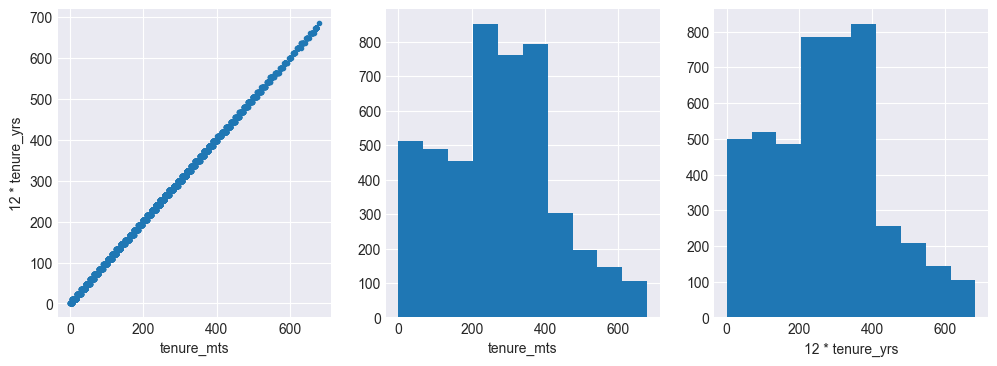

In [45]:
# -- make a scatterplot 
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].plot(train_V2['tenure_mts'], 12.*train_V2['tenure_yrs'], '.')
axs[0].set_xlabel("tenure_mts")
axs[0].set_ylabel("12 * tenure_yrs")
train_V2["tenure_mts"].hist(ax=axs[1])
axs[1].set_xlabel("tenure_mts")
(12.*train_V2["tenure_yrs"]).hist(ax=axs[2])
axs[2].set_xlabel("12 * tenure_yrs")

First we check if both variables contain the same missings as imputing missing `tenure_mts` from `tenure_yrs` would be a straighforward choice

In [46]:
# -- get the missing values for both
tenure_num_values = train_V2[["tenure_mts", "tenure_yrs"]].isna().sum(axis=1)
# -- test how many only have 1 missing value, so either tenure_mts or tenure_yrs, but not both present or absent
tenure_num_values[tenure_num_values == 1].any()

False

In [47]:
# -- get the missing values for both in the score dataset
tenure_num_values = score[["tenure_mts", "tenure_yrs"]].isna().sum(axis=1)
# -- test how many only have 1 missing value, so either tenure_mts or tenure_yrs, but not both present or absent
tenure_num_values[tenure_num_values == 1].any()

False

No, so `tenure_mts` `tenure_yrs` either both occurr in the dataset, or neither of them. So clearly, both expressing the same variable, once expressed in years, once in months and having established that we can't directly use either one to impute missing values in the other feature, it probably makes no sense to include both. Let's therefore omit the one with the lowest granularity : 

In [48]:
train_V2.drop(columns=['tenure_yrs'], inplace=True)
score.drop(columns=['tenure_yrs'], inplace=True)

numerical_input_features.remove("tenure_yrs")

### Treatment of missing records (instances with missing a lot of information)

We still see that for a large amount of features, there are somewhat 53 missings. Likely, these are records which are not complete. We can clearly see this in the histogram below, which plots a histogram of the the number of missing features per record. 

In [49]:
# number of features
print(f"Number of features train_V2 dataset after transformations so far: {len(train_V2.columns)}")
print(f"Number of features score dataset after transformations so far: {len(score.columns)}")

Number of features train_V2 dataset after transformations so far: 46
Number of features score dataset after transformations so far: 43


Text(0.5, 0, 'Missing features per record')

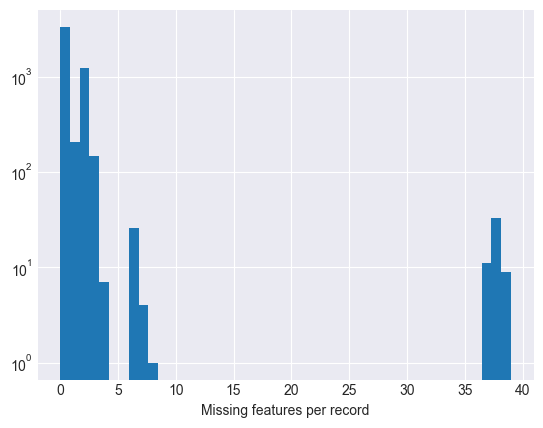

In [50]:
# -- a histogram of the amount of missing features per record
ax = train_V2.isnull().sum(axis=1).hist(bins=46, log=True)
ax.set_xlabel("Missing features per record")

Text(0.5, 0, 'Missing features per record')

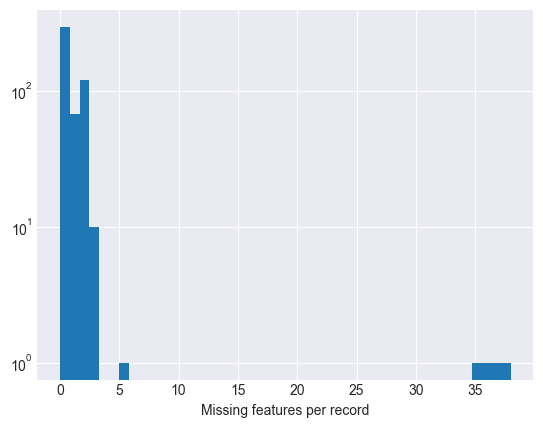

In [51]:
# -- a histogram of the amount of missing features per record in the score dataset 
ax = score.isnull().sum(axis=1).hist(bins=46, log=True)
ax.set_xlabel("Missing features per record")

We clearly see that for the majority of the records, the number of missing features is less than 10, however for a small amount, we have more than 35 of the features missing. It appears there are 53 such records. It makes sense to delete these rows alltogether. This is a minimal loss of data on a total of 5000 records (1.06 %). 

We see a similar image in the score data. There we have 4 instances.

In [52]:
train_V2.shape

(5000, 46)

In [53]:
#For a number of instances (53) data seems to be missing for a lot of features (24). These instances may be eliminated from the dataset
instances_missingsData = train_V2[train_V2.loc[:,['company_ic','claims_no','income_am','gold_status','nights_booked','gender','shop_am','retired','fam_adult_size','children_no','divorce','profit_last_am','sport_ic','crd_lim_rec','credit_use_ic','gluten_ic','lactose_ic','insurance_ic','prev_all_in_stay','profit_am','bar_no','age','marketing_permit','urban_ic']].isnull().sum(axis=1) == 24]
print(instances_missingsData.shape)
train_V2 = train_V2.drop(instances_missingsData.index)

(53, 46)


In [54]:
#For a number of instances (4) in score.csv data seems to be missing for a list of features. These will be eliminated from the score set, since comparable instances were removed from the training set
# These are not withheld in the list of clients 
instances_missingsData = score[score.loc[:,['company_ic','claims_no','income_am','gold_status','nights_booked','gender','shop_am','retired','fam_adult_size','children_no','divorce','profit_last_am','sport_ic','crd_lim_rec','credit_use_ic','gluten_ic','lactose_ic','insurance_ic','prev_all_in_stay','profit_am','bar_no','age','marketing_permit','urban_ic']].isnull().sum(axis=1) == 24]
print(instances_missingsData.shape)
score = score.drop(instances_missingsData.index)

(4, 43)


*** After export of these instances with missing more that 35% of data and looking in to the data we see that ***
There is data for these features (other features are NaN):
- spa_ic is 21x = 1 (2/21: outcome_damage_ic = 1)
- empl_ic is 40x = 0 (12/40: outcome_damage_ic = 1)
- married_cd is 53x = false (12/53: outcome_damage_ic = 1)
- claims_am is 20x = 0 (6/20: outcome_damage_ic = 1)

- spa_ic & claims_am & empl_ic has data for 6 of these instances 

# updated delete of instances missing data for a lot of features (see code -2, -1) - more explicit?
Commented next 2 code blocks 

In [55]:
# -- how many records have more than 35 missing features ? 
# drop_records = train_V2[train_V2.isnull().sum(axis=1) > 35]
# print(f"Number of records with > 35 missing features : {drop_records.shape[0]}")

In [56]:
# # -- let's drop those from the analysis
# train_V2.drop(index=drop_records.index, inplace=True)

In [57]:
# -- remaning records
# train_V2.shape
# number of features
print(f"Number of features train_V2 dataset after transformations so far: {len(train_V2.columns)}")
print(f"Number of features score dataset after transformations so far: {len(score.columns)}")

# number of features
print(f"Shape train_V2 dataset after transformations so far: {train_V2.shape}")
print(f"Shape score dataset after transformations so far: {score.shape}")


Number of features train_V2 dataset after transformations so far: 46
Number of features score dataset after transformations so far: 43
Shape train_V2 dataset after transformations so far: (4947, 46)
Shape score dataset after transformations so far: (496, 43)


### Imputation of missing data

In this section we impute the missing data.

In [58]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]

These are the features for which we still have missing values : 


avg_score_pos      1544
avg_score_neg      1113
tenure_mts          339
neighbor_income     186
cab_requests         35
presidential         35
dining_ic            35
shop_use             35
dtype: int64

In [59]:
missing_feats_categorical = ['presidential', 'dining_ic', 'shop_use']
missing_feats_continuous = ['tenure_mts', 'neighbor_income', 'cab_requests', 'avg_score_pos', 'avg_score_neg']

In [60]:
missing_features = train_V2.isnull().sum(axis=1).sort_values(ascending=False)  # total missng values, sorted
print("These are the rows which contain missing features : ")
row_idx_missing = missing_features[missing_features>0]
print(row_idx_missing)

These are the rows which contain missing features : 
Id
2504    8
863     7
7       7
2895    7
4286    7
4642    6
627     6
3167    6
3474    6
3727    6
4548    6
3606    6
4940    6
3015    6
3142    6
3845    6
3170    6
1557    6
3564    6
1566    6
1267    6
3166    6
3149    6
1514    6
3192    6
3330    6
4644    6
781     6
2387    6
1782    6
1021    6
605     4
301     4
1409    4
473     4
2618    4
845     4
3510    4
1125    3
3559    3
604     3
3400    3
2910    3
3790    3
2658    3
2285    3
3405    3
739     3
1297    3
1084    3
3226    3
4904    3
1881    3
132     3
3124    3
4303    3
2742    3
4487    3
571     3
1863    3
575     3
172     3
4492    3
1854    3
2509    3
4898    3
2738    3
1547    3
2666    3
2817    3
3100    3
1072    3
3493    3
638     3
1179    3
333     3
1712    3
1626    3
2843    3
4820    3
3864    3
326     3
1192    3
2690    3
1239    3
2693    3
1721    3
668     3
1200    3
2430    3
3880    3
3881    3
3905    3
4579    3
294 

Instead of separating between numerical and categorical values, we will use a **KNNImputer** to make optimal use of possible correlations between the features. **However**, as the KNN technique is sensitive to the scale of the features (it uses a distance based metric), we first have to rescale the features before being able to use a KNNImputer. Most of our features are categorical between 0 and 1, so we'll just use a MinMaxScaler between 0 and 1 to rescale to that fixed range...

In [61]:
# -- first define the min max scaler and apply to the original data
imputer_scaler = MinMaxScaler().set_output(transform="pandas")

# -- set the target features aside as we will apply the imputer to the score as well, which lacks the target features,
#    so only use the input feature for transformation & imputing
train_V2_outcome = train_V2[target_features]
train_V2_scaled = imputer_scaler.fit_transform(train_V2.drop(columns=target_features))
score_scaled = imputer_scaler.transform(score)

# -- next define the imputer having 5 neighbours (default) and uniform weights
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform').set_output(transform="pandas")

# -- apply to the scaled data
train_V2_scaled = imputer_knn.fit_transform(X=train_V2_scaled)
score_scaled = imputer_knn.transform(score)

# -- and apply the inverse transform
train_V2_inv_transformed = imputer_scaler.inverse_transform(train_V2_scaled)
score_inv_transformed = imputer_scaler.inverse_transform(score_scaled) 

# -- interestingly, the set_output(transform="pandas") is not implemented yet on the inverse transform in sklearn,
#    so we will pour the numpy array into a dataframe ourselves (see:  https://github.com/scikit-learn/scikit-learn/issues/27843) 
#    here we put back the outcome variables which we set aside before we fitted the scaler transform
train_V2 = pd.concat( [ pd.DataFrame(train_V2_inv_transformed, columns=train_V2_scaled.columns).set_index(train_V2_scaled.index), train_V2_outcome ], axis=1 )
score = pd.DataFrame(score_inv_transformed, columns=score_scaled.columns).set_index(score_scaled.index)

In [63]:
# we print the unique values in the replaces values for the categorial features in order to 
# test whether they are categorical & no interpolated somehow
for feat_name in missing_feats_categorical:
    print(f"Unique values in {feat_name} replaced missing")
    print(train_V2.loc[row_idx_missing.index, feat_name].unique())

Unique values in presidential replaced missing
[0. 1.]
Unique values in dining_ic replaced missing
[0.  0.2 1. ]
Unique values in shop_use replaced missing
[0.  0.2 1. ]


In [64]:
# ha! so we have a few little bastard slipping through, let's correct !
train_V2.loc[train_V2['dining_ic'] < 0.5,'dining_ic'] = 0.
train_V2.loc[train_V2['shop_use'] < 0.5,'shop_use'] = 0.

score.loc[score['dining_ic'] < 0.5,'dining_ic'] = 0.
score.loc[score['shop_use'] < 0.5,'shop_use'] = 0.

Now finally test whether we still have missing values

In [65]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]


print(f"Total amount of missing values in the dataframe : {train_V2.isnull().sum().sum()}")

These are the features for which we still have missing values : 
Total amount of missing values in the dataframe : 0


In [66]:
missing_rows = score.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]


print(f"Total amount of missing values in the dataframe : {score.isnull().sum().sum()}")

These are the features for which we still have missing values : 
Total amount of missing values in the dataframe : 0


## Anomaly and outlier detection

Now, before moving onwards, we still want to have a look to possible outliers in the data in order to decide what to do with them. Let's start with some simple visualisations like boxplots and histograms to get a feeling for the distribution of the features. 

### Univariate analysis

In [67]:
# -- for the plots
nrows = 6
ncols = 8

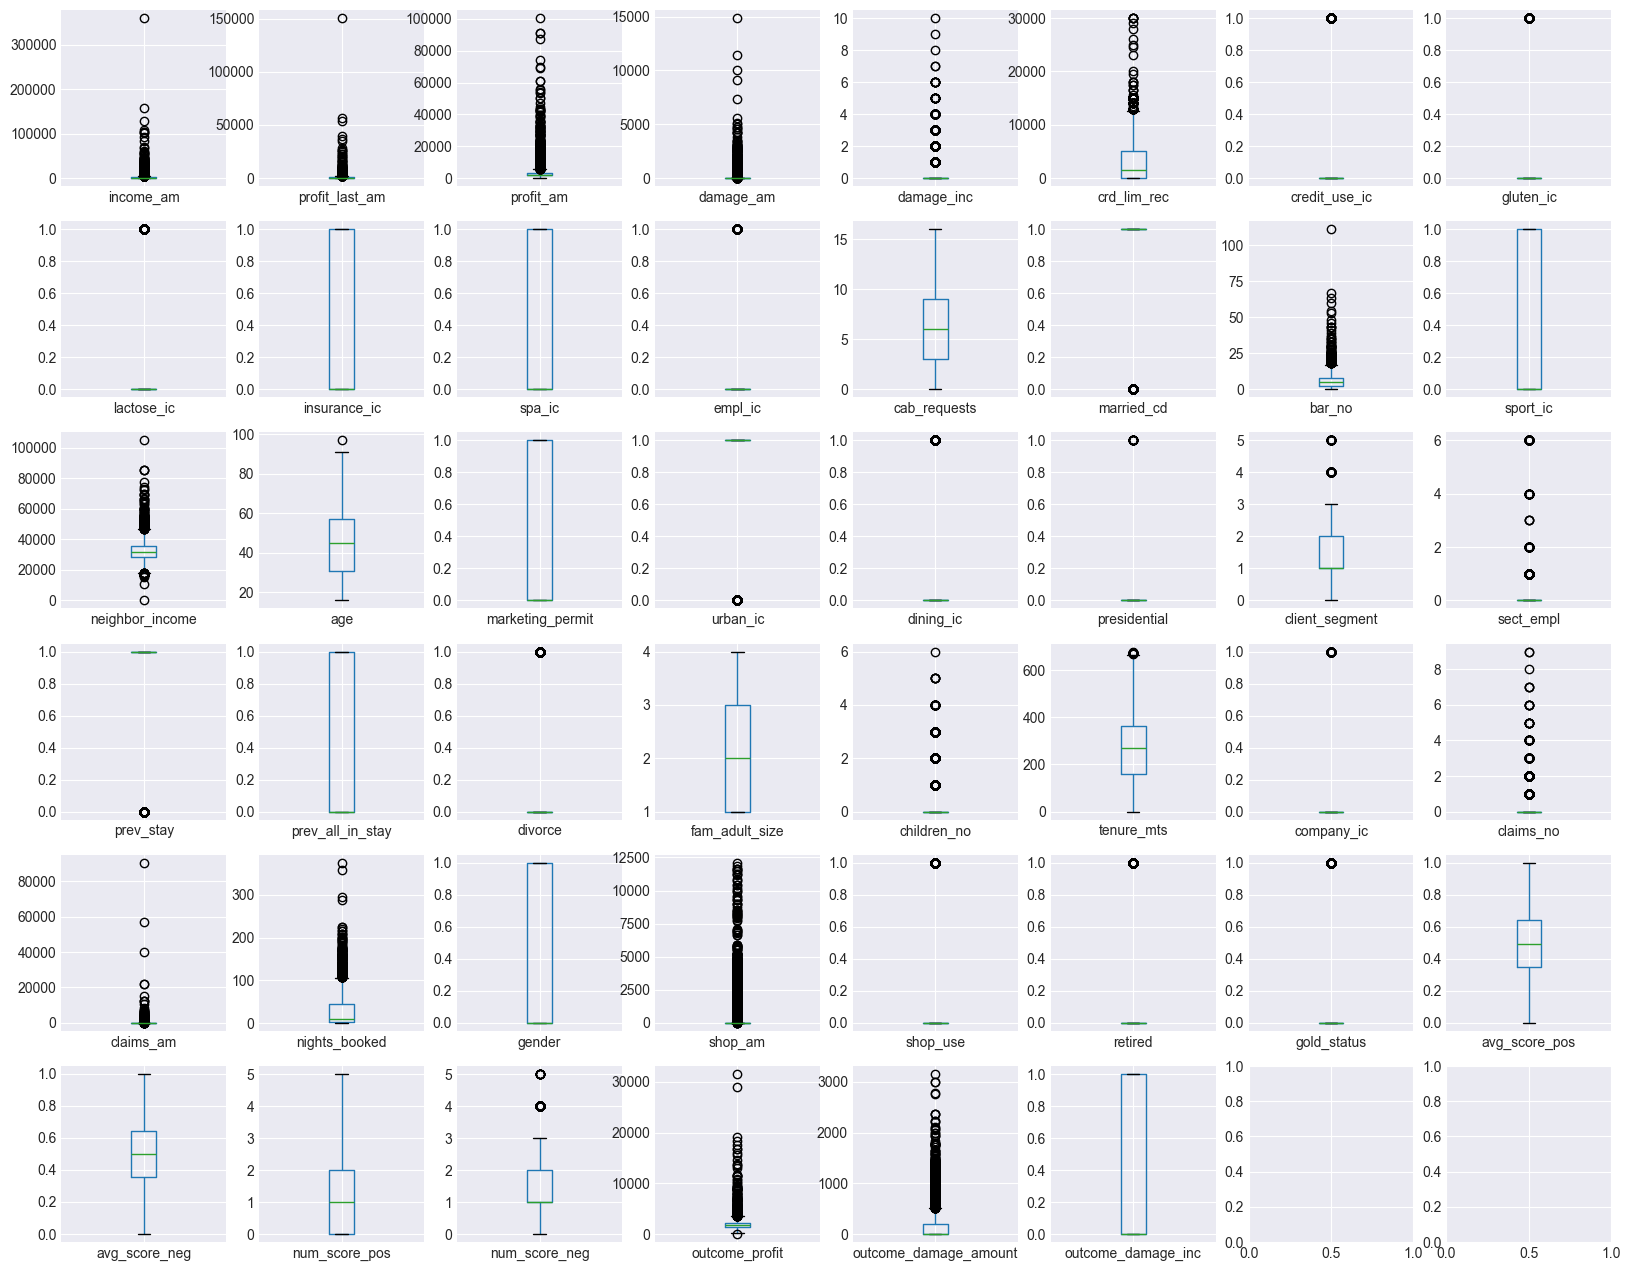

In [68]:
# -- we first make some boxplots for every feature
fig, axs = plt.subplots(nrows, ncols, figsize=(20,16))
for idx, feat_name in enumerate(train_V2.columns):
    row = idx // ncols
    col = idx % ncols
    train_V2.boxplot([feat_name], ax=axs[row][col])

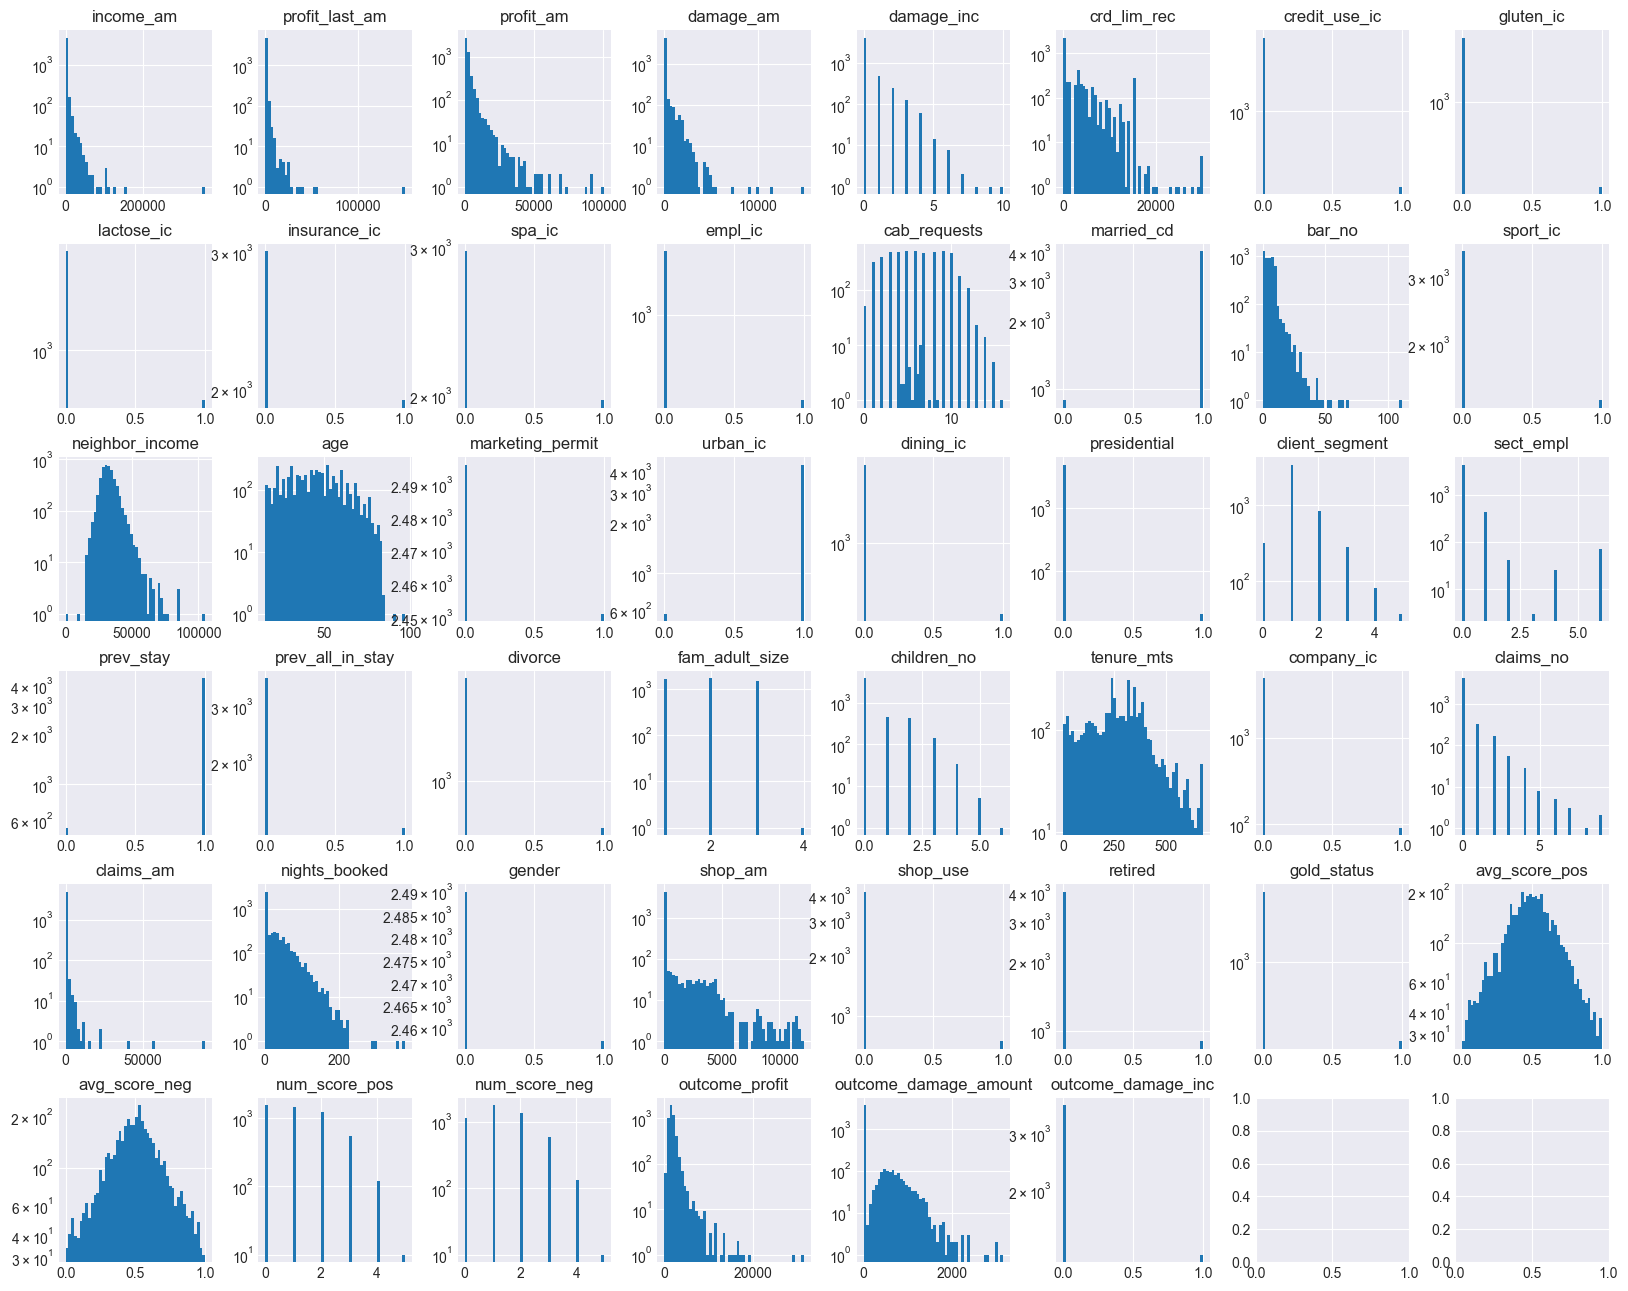

In [69]:
# -- and here we do the same with the histograms
fig, axs = plt.subplots(nrows, ncols, figsize=(20,16))
for idx, feat_name in enumerate(train_V2.columns):
    row = idx // ncols
    col = idx % ncols
    train_V2.hist(feat_name, bins=50, ax=axs[row][col], log=True)

We can already make a couple of interesting observations : 
- There (visually) seem so be some outliers present in the distributions for `income_am`, `profit_last_am`, `damage_am`, `bar_no`, `claims_am`, and `outcome_profit`
- There seem to be some records which show a total number of nights booked (`nights_booked`) at the chain of 0 ! This is rather surprising given that these

Let's look at a few of the outliers : 

In [70]:
train_V2[train_V2['income_am'] > 150000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
709,157697.0,8.0,31325.0,0.0,0.0,8000.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,14.0,0.0,33188.4,45.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,2.0,0.0,242.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.378836,0.262060,3.0,3.0,11451.15,0.0,0
3763,360577.0,150537.0,61264.0,4771.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,1.0,8.0,1.0,48846.0,46.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,3.0,0.0,26.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.332470,0.504499,2.0,2.0,29046.40,1288.2,1


In [71]:
train_V2[train_V2['damage_am'] > 6000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2112,5247.0,1492.0,12741.0,9136.0,7.0,28000.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,3.0,0.0,34823.0,46.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,1.0,575.0,0.0,0.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.026500,0.703839,1.0,1.0,2775.97,1416.26,1
2253,227.0,0.0,1620.0,11394.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,2.0,0.0,22561.0,52.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,0.0,358.0,0.0,0.0,0.0,224.0,1.0,0.0,0.0,0.0,0.0,0.326955,0.416902,0.0,0.0,2080.49,733.00,1
2718,227.0,0.0,4808.0,7321.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,1.0,28983.0,25.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,238.0,0.0,0.0,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.623210,0.522044,0.0,0.0,1353.37,0.00,0
3931,4647.0,1725.0,13871.0,10025.0,9.0,14000.0,1.0,0.0,0.0,1.0,1.0,0.0,13.0,1.0,10.0,0.0,51673.0,35.0,1.0,1.0,0.0,0.0,4.0,6.0,1.0,1.0,0.0,3.0,2.0,308.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.312075,0.820847,3.0,3.0,9125.84,1538.22,1
4768,53682.0,61.0,29712.0,14866.0,3.0,30000.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,1.0,5.0,0.0,34334.0,36.0,1.0,1.0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,3.0,0.0,359.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.257344,0.746133,1.0,1.0,2071.03,1046.63,1


In [72]:
train_V2[train_V2['bar_no'] > 100 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2512,2341.0,0.0,4922.0,0.0,0.0,3000.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,111.0,0.0,39147.0,51.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,26.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.569805,0.473527,0.0,0.0,1970.7,452.61,1


In [73]:
train_V2[train_V2['claims_am'] > 30000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
818,16991.0,0.0,27679.0,0.0,0.0,12000.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,1.0,16.0,0.0,26044.0,59.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,122.0,0.0,1.0,90587.0,83.0,0.0,0.0,0.0,1.0,0.0,0.456201,0.440444,0.0,0.0,1726.72,829.63,1
2530,227.0,0.0,1620.0,0.0,0.0,11000.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0,1.0,2.0,1.0,29817.0,43.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,1.0,216.0,0.0,2.0,57222.0,102.0,1.0,0.0,0.0,0.0,0.0,0.641449,0.951726,1.0,1.0,1312.66,0.00,0
4550,286.0,0.0,2959.0,628.0,3.0,2500.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,4.0,1.0,34841.0,39.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,324.0,0.0,1.0,40265.0,51.0,0.0,0.0,0.0,0.0,0.0,0.821716,0.902322,2.0,2.0,1587.44,0.00,0


So there seems to be a fairly rich person in the dataset with very high income (>200000), but also high `profit_last_am` which seems to be in client segment 5  (a higher segment seems correlated with income (not shown)), so which probably makes sense. We don't think this should necessarily be considered as an outlier. 

### Multivariate analysis

In addition to the univariate analysis above, we also looked at an unsupervised technique for outlier detection, namely **isolation forests**

**TODO** : argumenteren dat de gevonden 11% "outliers" dan niet echt outliers te noemen zijn waardoor we ze er gewoon in laten..

In [ ]:
# Can not handle missing values
# Fitting default isolation forest for anomaly/outlier detection
# Importing the correct class as usual
from sklearn.ensemble import IsolationForest

# Checking which hyperparameters are available
# print(f"Hyperparamerters for IsolationForest class: {IsolationForest().get_params()}")

# Initializing model
if_model = IsolationForest(n_estimators=100, random_state=seed)

# Fitting (only X data, because unsupervised)
X_train_V2 = train_V2.drop(columns=['outcome_profit','outcome_damage_inc','outcome_damage_amount'], inplace=False)
X_alldata = pd.concat([X_train_V2,score])

if_model.fit(X=X_train_V2)

# Predicting on the same data
y_pred_train = if_model.predict(X=X_train_V2)

# Checking frequency table of predicted values
print('Frequency table of predicted values:')
pd.Series(y_pred_train).value_counts(normalize=True)

# Visualisations and exploratory analysis

Now that we have reasonably clean data, let's perform some initial exploratory analysis, correlation plots, etc...

## Correlation analysis

<Axes: >

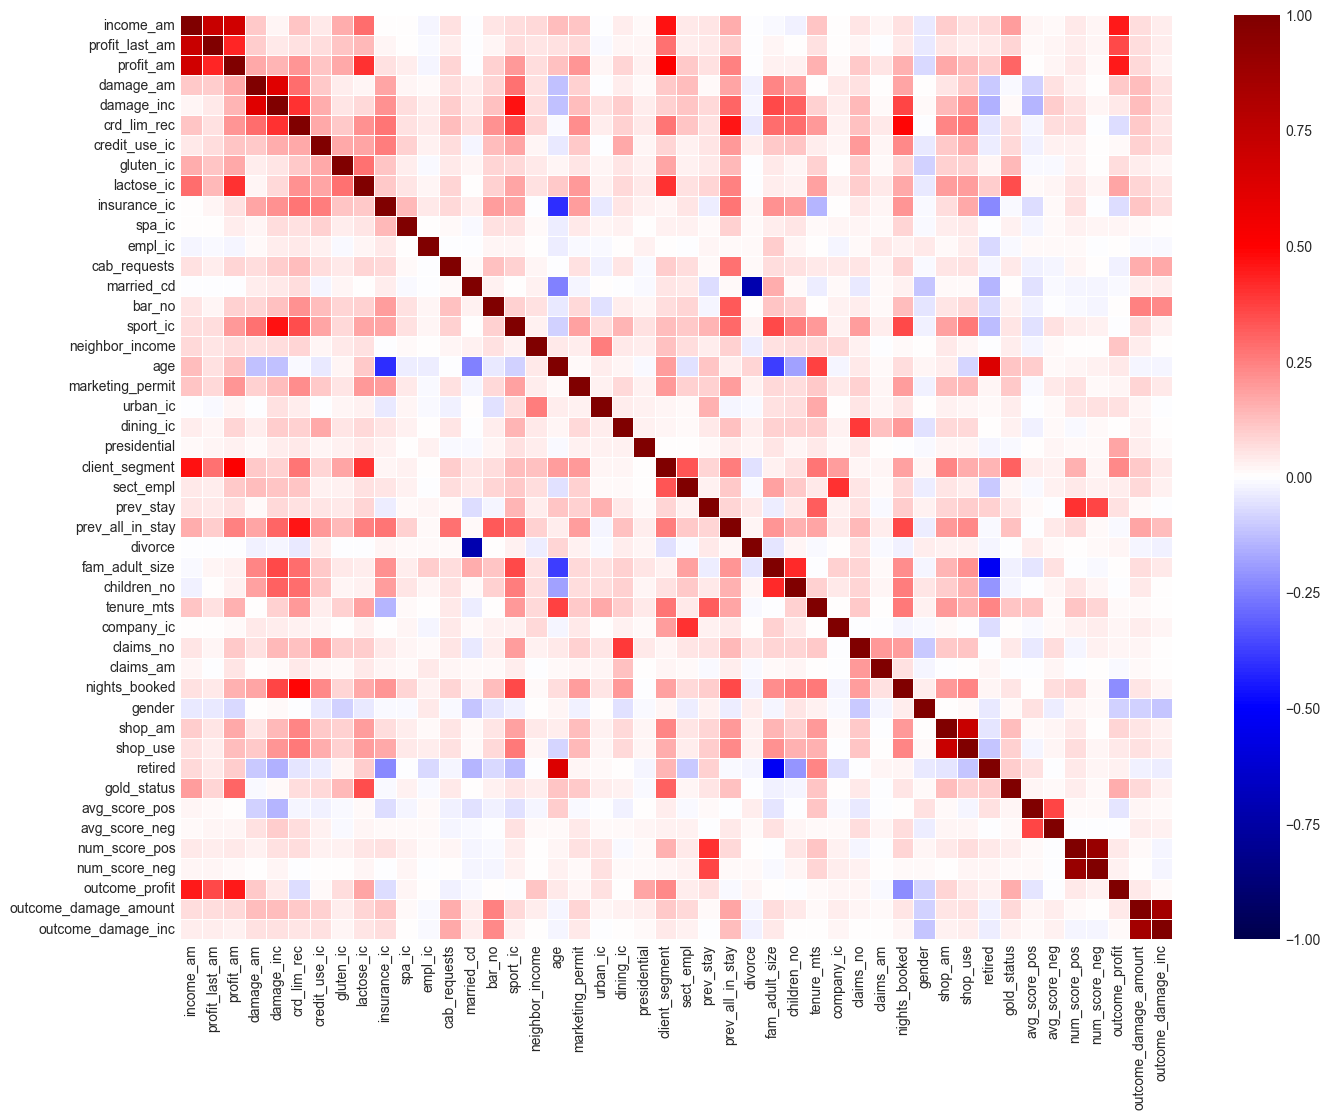

In [75]:
# -- this plots the correlation matrix
#    we adjusted the scale and colors a little to make the positive or negative correlations stand out, using the seismic colormap for this
corrmat = train_V2.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(corrmat, vmin=-1, vmax=1, center=0, cmap="seismic",  linewidth=.5)

Conclusies : divorce & married zijn gecorreleerd, te verwachten, komen geen onlogische dingen uit...

In [ ]:
# The outcome to maximize is profit - damage

# don't assign to dataframe just yet ???
train_V2['revenue'] = train_V2['outcome_profit'] - train_V2['outcome_damage_amount']

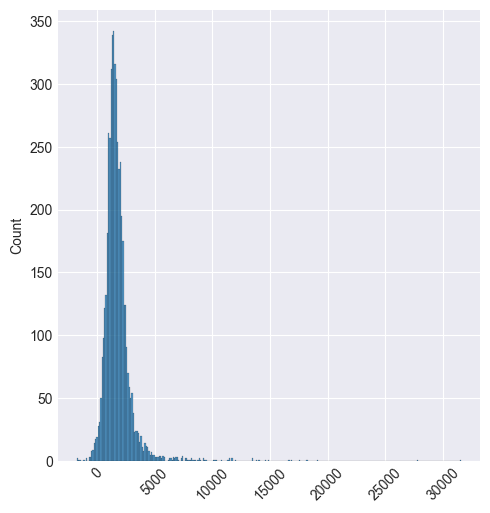

In [77]:
# Checking univariate distribution of the revenue
sns.displot(train_V2['outcome_profit'] - train_V2['outcome_damage_amount']);  # With seaborn for a change
plt.xticks(rotation=45); # Rotating x labels

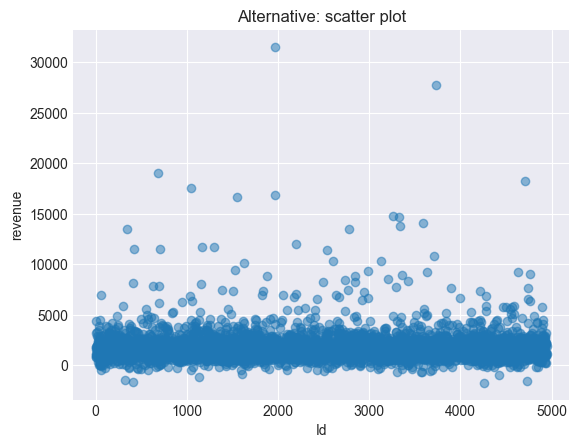

In [78]:
# But I guess a scatter plot would've done well also

plt.scatter(x = range(0, 0 + len(train_V2)),y=train_V2['outcome_profit'] - train_V2['outcome_damage_amount'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('Id');
plt.ylabel('revenue');
plt.title('Alternative: scatter plot');
plt.show() 

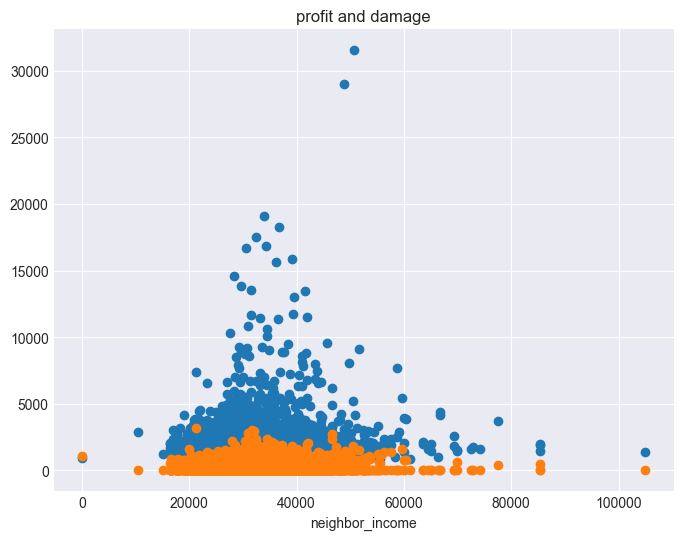

In [79]:
# Plotting
x = 'neighbor_income'
plt.figure(figsize=(8, 6))
plt.scatter(x=train_V2[x], y=train_V2['outcome_profit']);
plt.scatter(x=train_V2[x], y=train_V2['outcome_damage_amount']);
plt.title('profit and damage');
plt.xlabel(x);

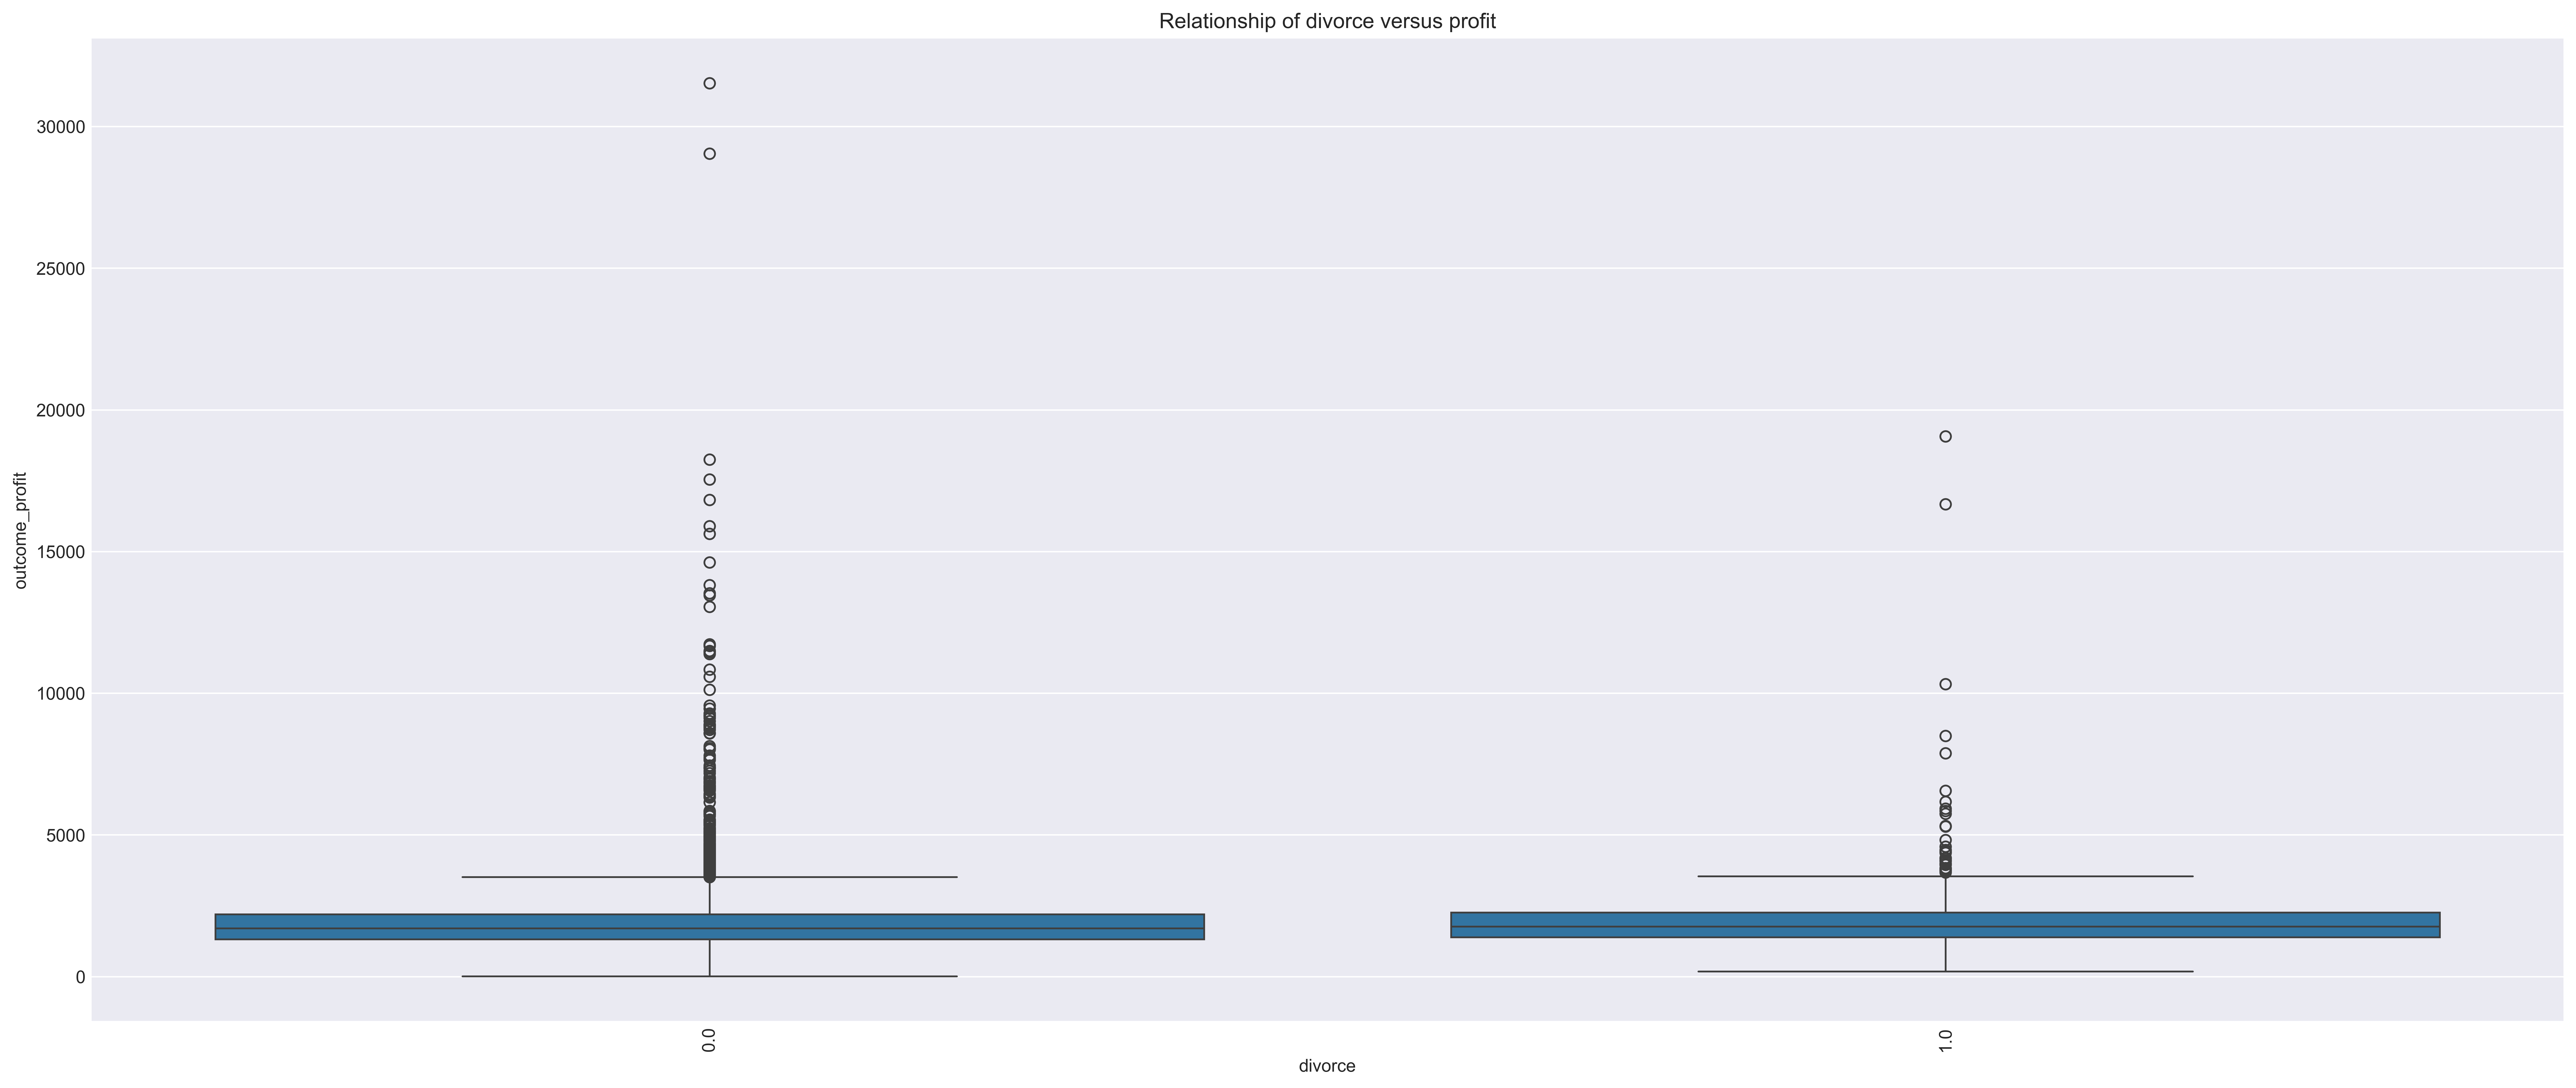

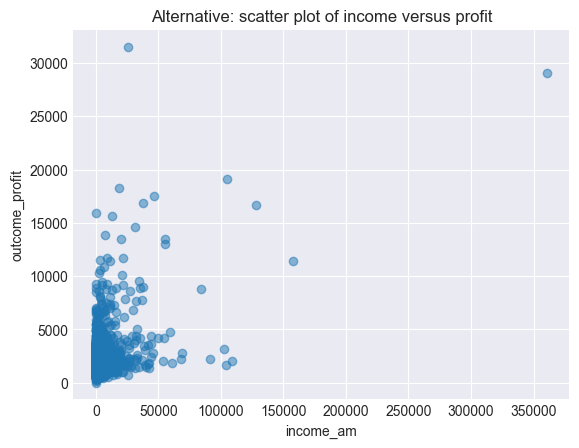

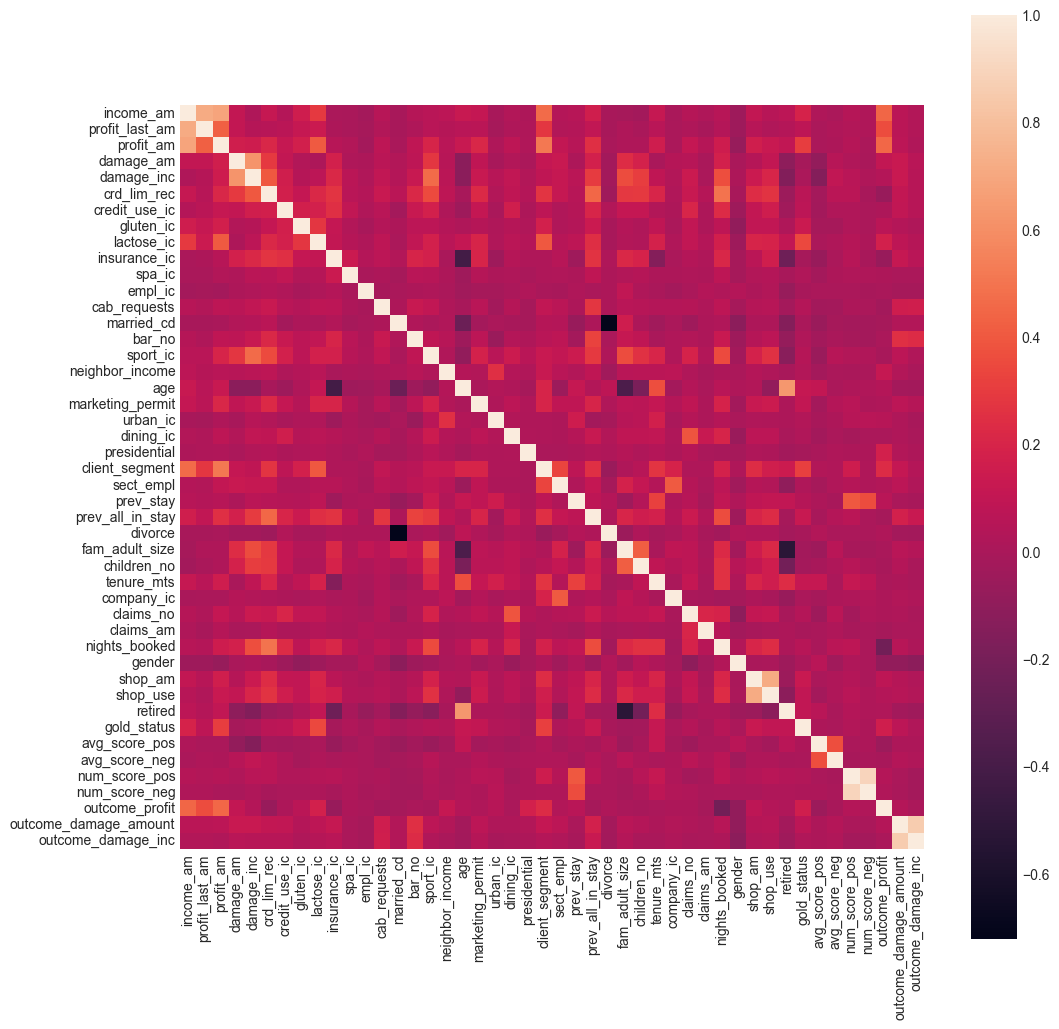

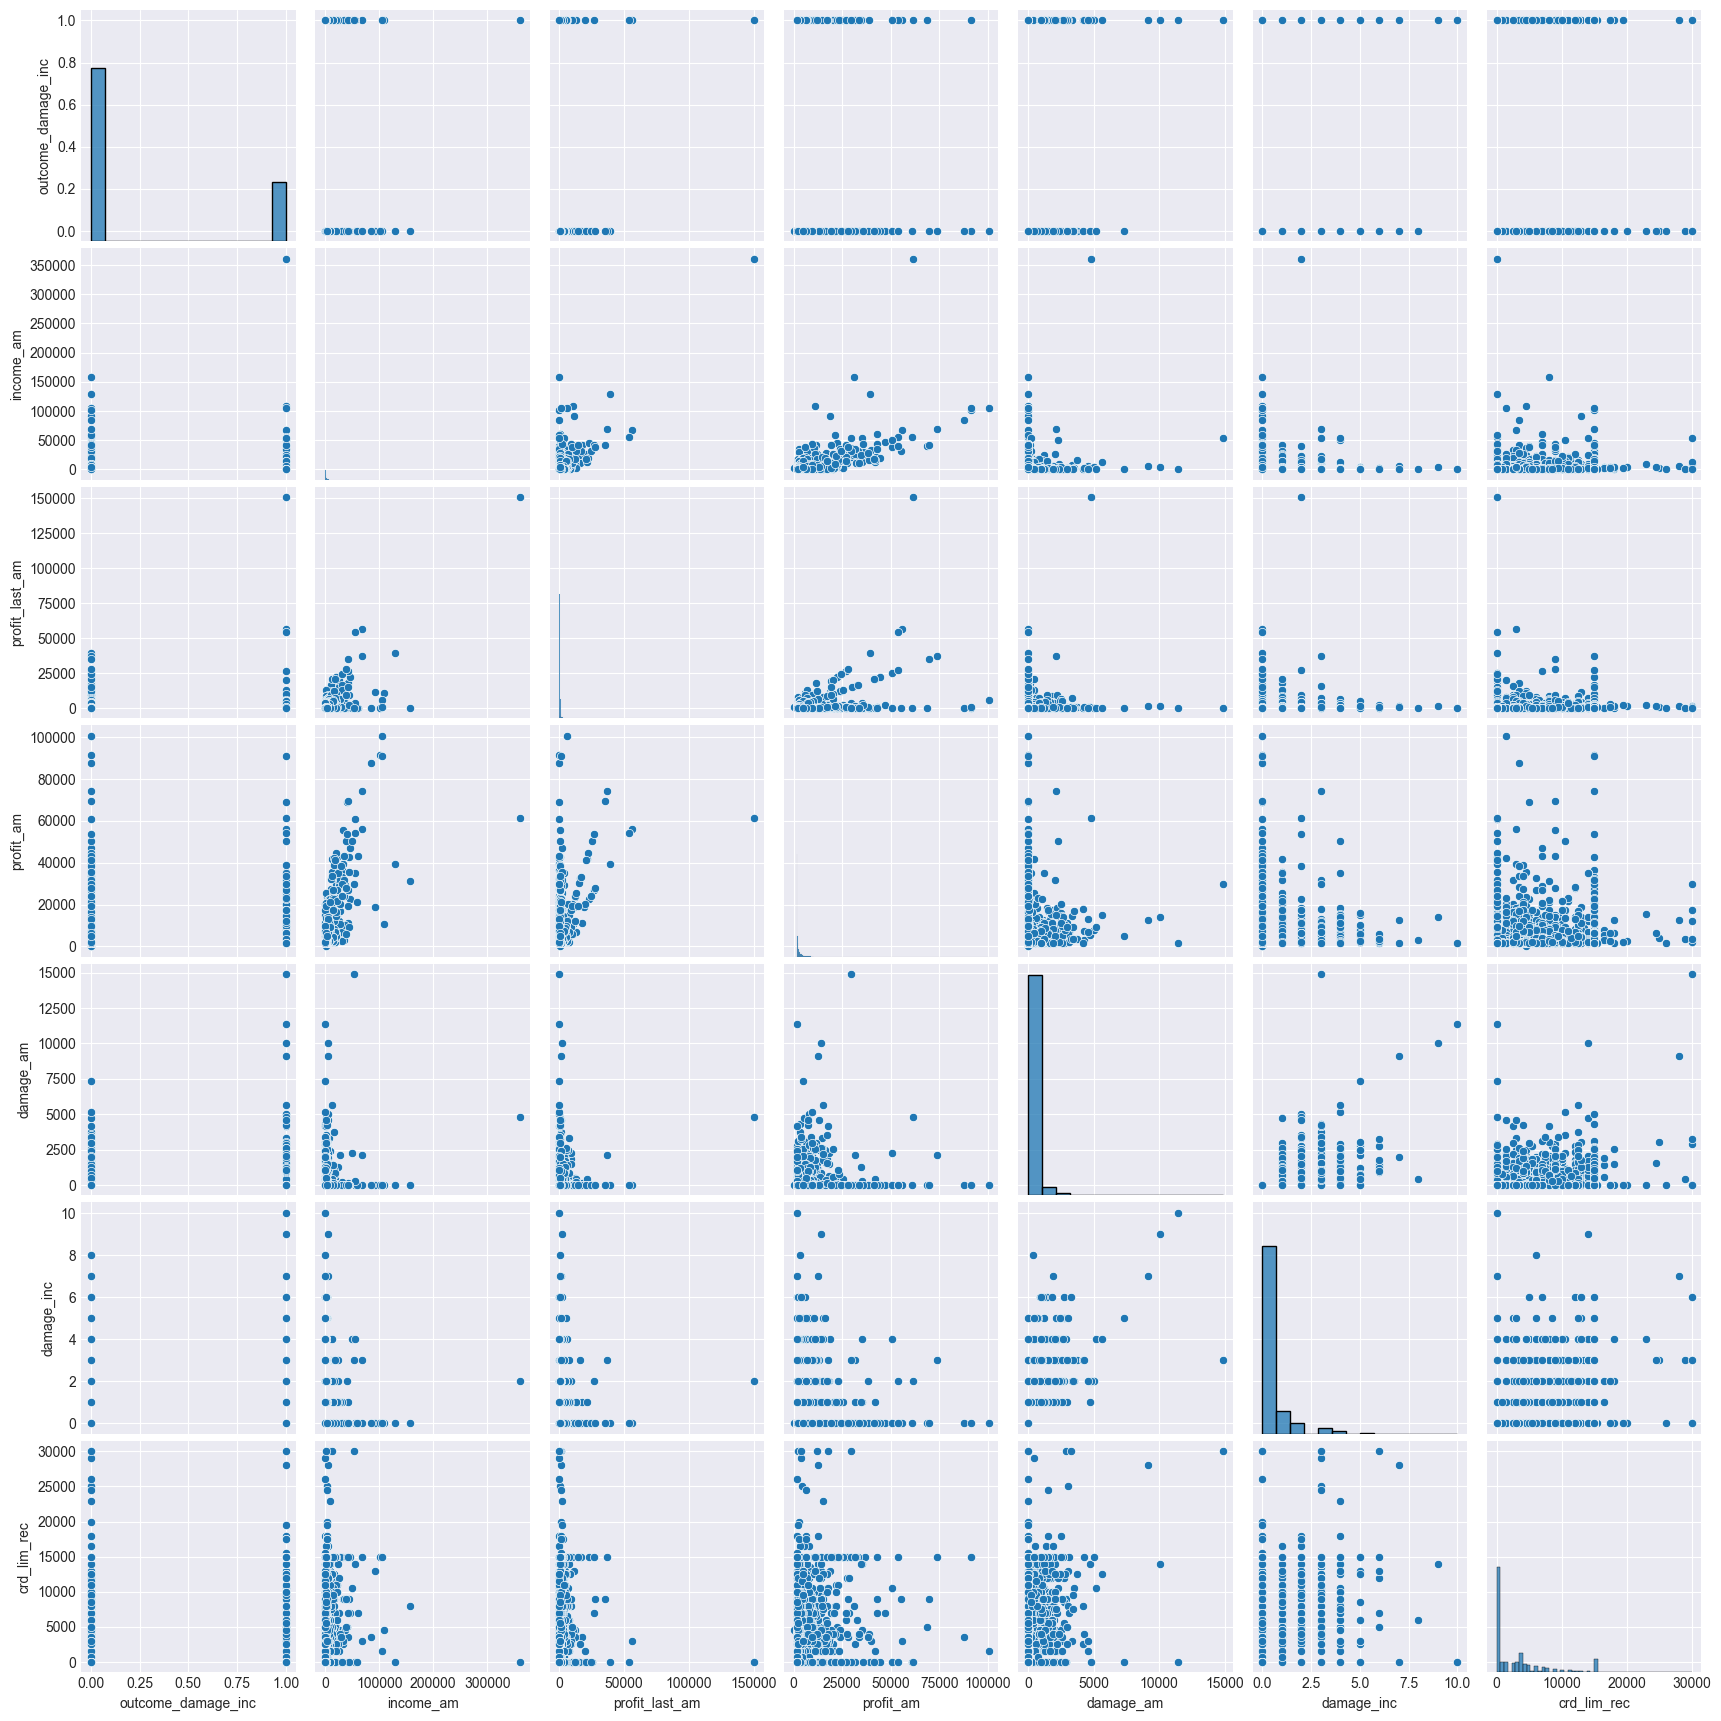

In [80]:
# Boxplot-type for year built vs SalePrice
plt.figure(figsize=(25, 10), dpi=500)  # Bumping up image size and DPI for better viewing
sns.boxplot(x='divorce', y='outcome_profit', data=train_V2);
plt.xticks(rotation=90);  # To rotate x-axis labels
plt.title('Relationship of divorce versus profit');
plt.show()  # remember: necessary to do this when trying to plot multiple plots from a single cell!

# But I guess a scatter plot would've done well also
plt.scatter(x=train_V2['income_am'], y=train_V2['outcome_profit'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('income_am');
plt.ylabel('outcome_profit');
plt.title('Alternative: scatter plot of income versus profit');
plt.show() 

# Correlation matrix between features
corrmat = train_V2.corr(numeric_only=True)  # Since Pandas 2.0 you need to supply this attribute
plt.figure(figsize=(12, 12));
sns.heatmap(corrmat, vmax=1, square=True);
# Note, we keep SalePrice in here as well, proceed with caution (no data snooping!)

# Scatterplot matrix (might take a while)
plot_cols = ['outcome_damage_inc', 'income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc', 'crd_lim_rec']
sns.pairplot(train_V2[plot_cols], height=2.5);

- trainen op log outcome profit?
- 

In [74]:
target_features

['outcome_profit', 'outcome_damage_amount', 'outcome_damage_inc']

In [ ]:
# X_train_norm.head()

# Model training


Goal of the What do we need to predict? Is it available as outcome in our data
1. the revenue per client (= profit - damage)
    - needs to be calculated
2. predict which clients will cause damage
    - outcome_damage_inc
3. predict the amount of damage fot those who will cause damage / wreak havoc
    - outcome_damage_amount

Calculate revenue


## TODO

- es trainen op apart amount profit & damage, maar ook es op verschil (revenue)

## verdeling

- Bino : GBM
- Marijke : RF
- Dries : SVR/SVC

## GBM

### Standardizing / train_test_split

In [ ]:
# Standardizing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas')
train_v2_stan_df = scaler.fit_transform(X=train_V2)

#

#train_v2_stan_df.drop('outcome_profit', axis=1)
#train_v2_stan_df.drop('outcome_damage_inc', axis=1)
#train_v2_stan_df.drop('outcome_damage_amount', axis=1)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1), 
                                                    train_V2["outcome_profit"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

GradientBoostingRegressor().get_params()

params = {'n_estimators': 500, 
          'max_depth': 4, 
          'min_samples_split': 2,
          'learning_rate': 0.01}

gbm = GradientBoostingRegressor(loss='squared_error',
                                 random_state=seed,
                                 **params) 

gbm.fit(X=X_train, y=y_train) 

# Step 4 - Getting predictions
gbm_preds = gbm.predict(X=X_test)

# Print R2 results
print('Train R2: %.3f' % gbm.score(X=X_train, y=y_train))
print('Test R2: %.3f' % gbm.score(X=X_test, y=y_test))

## Random forest
### Model to predict revenue per client

Goal of the What do we need to predict? Is it available as outcome in our data
1. the revenue per client (= profit - damage)
    - needs to be calculated

In [ ]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue'], axis=1), # features DF
#X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue','score_pos','score_neg','not_null_pos_columns','not_null_neg_columns'], axis=1), # features DF
                                                    train_V2['revenue'],   # target DF/series
                                                    test_size=0.2, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results

In [ ]:
# Random Forest for classification - random search 3-fold CV - this can take a while
from sklearn.ensemble import RandomForestRegressor

# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=10)]  # list comprehension because we want integers!
# max_features = [int(x) for x in np.linspace(start=5, stop=40, num=5)] 
max_depth = [int(x) for x in np.linspace(start=5, stop=80, num=5)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.85, 0.9, 0.95]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4]
bootstrap = [True]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
rf = RandomForestRegressor()

# Initializing random search CV object
rf_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
                                          param_distributions=hyperparam_grid, 
                                          n_iter=n_hyperparams_sample, 
                                          cv=kfold,
                                          verbose=2, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
rf_hyperparam_tuning_random.fit(X=X_train, y=y_train)

print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_revenue_best = rf_hyperparam_tuning_random.best_estimator_
rf_revenue_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_revenue_best_y_train_pred = rf_revenue_best.predict(X=X_train)
rf_revenue_best_y_test_pred = rf_revenue_best.predict(X=X_test)

# Checking accuracy manually
print('Train R2: %.3f' % rf_revenue_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_revenue_best.score(X=X_test, y=y_test))


In [ ]:
pickle.dump(rf_revenue_best, open('..\\RF_model_revenue.pkl','wb'))

In [ ]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_hyperparam_tuning_random.cv_results_)

# Scatter plot of selection of hyperparams vs performance
plot_hyperparams = ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_n_estimators', 'param_max_features']  
# in the .cv_results_ there is always a 'param_' prefix!

for param in plot_hyperparams:
    plt.figure(); # This command will help in the plots not 'falling' on top of each other ;)
    plt.scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7); # alpha to get some opacity
    plt.xlabel(param);
    plt.ylabel('CV R2')
    plt.title(f"Hyperparameter: {param} vs. CV R2")

This picture brings some nuance to the 'best' random forests: let's start with `max_depth`: apparently, you can find similarly good trees at lower depth; but the very lowest depths perform rather bad. This may give us a bit of benefit in terms of generalization error. 

For the minimal samples per leaf (`min_samples_leaf`), the picture really prefers not to shy away from small leafs: it seems that going into unique values is worth it. Finally, let's see whether we need a lot of trees or not.

With regards to the amount of trees `n_estimators`: you don't seem to necessarily need many trees in your forest to get a good model. This is good to know for future training, but realize that with more complex forests, you may need more trees to improve generalization error. So let's not restrict the forests too much in the grid search. 

Now, do realize that these kinds of analyses are to be taken with a grain of salt in the section on GBMs we go 1 small step beyond and make plot that take 2 hyperparameters at once in consideration, which might already help a bit more. But for now, we'll keep it simple.

Another word of caution: sometimes, due to randomness, the best was at the boundary of the search space, let's increase the options a bit more in the grid search. Since we don't care too much about the size of the object, we're probably better of grid searching higher values, but with less options (this keeps the training time low).

#### Learning curve

In [ ]:
# Executing our learning curve function to plot (takes around 5 minutes)
cuf.plot_learning_curve(model=rf_revenue_best, 
                    X=train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue'], axis=1), 
                    y=train_V2['revenue'], 
                    cv=5, 
                    num_show=20)
plt.show()

In [ ]:
#revenue_preds = rf_revenue_best.predict(score)
score['revenue_pred'] = rf_revenue_best.predict(score)
#score['revenue_pred'] = rf_revenue_best.predict(score.drop(['score_pos','score_neg','not_null_pos_columns','not_null_neg_columns'], axis=1))

In [ ]:
score.sort_values('revenue_pred', ascending=False).head(10)

### Model to predict which clients will cause damage

Goal of the What do we need to predict? Is it available as outcome in our data

2. predict which clients will cause damage
    - outcome_damage_inc


Train-test set split for output = output_damage_inc

In [ ]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','revenue','outcome_profit'], axis=1), # features DF
                                                    train_V2['outcome_damage_inc'],   # target DF/series
                                                    test_size=0.4, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results


In [ ]:
# Random Forest for classification - random search 3-fold CV - this can take a while
from sklearn.ensemble import RandomForestClassifier

# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]  # list comprehension because we want integers!
max_features = [int(x) for x in np.linspace(start=5, stop=150, num=20)] 
max_depth = [int(x) for x in np.linspace(start=2, stop=40, num=10)]
max_depth.append(None)  # adding 'None' option as well
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
rf = RandomForestClassifier()

# Initializing random search CV object
rf_hyperparam_tuning = RandomizedSearchCV(estimator=rf, 
                                          param_distributions=hyperparam_grid, 
                                          n_iter=n_hyperparams_sample, 
                                          cv=kfold,
                                          verbose=2, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Executing / fitting the random search 
rf_hyperparam_tuning.fit(X=X_train, y=y_train)
print('Optimal hyperparameter values according to our random search: \n{}' .format(rf_hyperparam_tuning.best_params_))

# Refitting the optimal model on the whole training dataset
rf_damageInd = rf_hyperparam_tuning.best_estimator_
rf_damageInd.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_damageInd_y_train_pred = rf_damageInd.predict(X=X_train)
rf_damageInd_y_test_pred = rf_damageInd.predict(X=X_test)

# Checking accuracy manually
print('Train accuracy of the refitted model: %.3f' % rf_damageInd.score(X=X_train, y=y_train))
print('Test accuracy of the refitted model: %.3f' % rf_damageInd.score(X=X_test, y=y_test))

# Classification report 
target_names = ['no damage', 'damage']
print(classification_report(y_true=y_test, y_pred=rf_damageInd_y_test_pred, target_names=target_names))

In [ ]:
pickle.dump(rf_damageInd, open('..\\RF_model_damage_inc.pkl','wb'))

In [ ]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_hyperparam_tuning.cv_results_)

# Scatter plot of selection of hyperparams vs performance
plot_hyperparams = ['param_max_depth', 'param_min_samples_leaf', 'param_n_estimators']  
# in the .cv_results_ there is always a 'param_' prefix!

for param in plot_hyperparams:
    plt.figure(); # This command will help in the plots not 'falling' on top of each other ;)
    plt.scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7); # alpha to get some opacity
    plt.xlabel(param);
    plt.ylabel('CV R2')
    plt.title(f"Hyperparameter: {param} vs. CV Accuracy")

#### Probability of damage

In [ ]:
# Decision cutoff/threshold tuning for classification models
# Choose a cutoff/threshold value
cutoff = 0.7

# Refitting an RF with the tuned hyperparameters from the previous cell
print(f"Checking parameters of rf_damageInd: {rf_damageInd}")

# Getting performances & classification report
print('Train accuracy: %.3f' % rf_damageInd.score(X=X_train, y=y_train))
print('Test accuracy: %.3f' % rf_damageInd.score(X=X_test, y=y_test))
target_names = ['No damage', 'Damage']
print(classification_report(y_test, (rf_damageInd.predict_proba(X=X_test)[:, 1] > cutoff), target_names=target_names))

In [ ]:
# Confusion matrix for random forest
from sklearn.metrics import confusion_matrix

rf_damage_pred_proba = rf_damageInd.predict_proba(X_test)

# If you sum per row you just get 1, to know which proability is what, they are ordered as in the classes_ attribute
print(f"Ordering of the target classes: {rf_damageInd.classes_}")  # So False for col 0, True for col1!

# cleaner since col 2 is 1 - col1:
print(f"Probabilities of damage: {rf_damage_pred_proba[0:5, 1]}")
# rf_damageInd_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=rf_damage_pred_proba)
# print(rf_damageInd_confusion_matrix)

In [ ]:
# Plotting decision cutoff vs. precision
# Making a grid of potential cutoff values (between 0, 1)
cutoffs = np.arange(1, 101) / 100  # Range of cutoffs

# Getting the test precisions with  list comprehension (could be a loop as well)
precisions = [y_test[rf_damage_pred_proba[:,1] > c].mean() for c in cutoffs]
#[rf_damageInd.predict_proba(X=X_test)[:,1] > c].mean() is a way to get the proportion of positively predicted values

# Plotts
plt.figure();
plt.plot(cutoffs, precisions);
plt.xlabel('Cutoff');
plt.ylabel('Precision (PPV)');
plt.title('Potential cutoffs versus resulting test precisions');

#### Calibration

In [ ]:
# Calibration curve 
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_estimator(estimator=rf_damageInd,
                                  X=X_test, 
                                  y=y_test,
                                  n_bins=5,
                                  strategy='uniform');

In [ ]:
# Calibrating a RF model
# Importing necessary classes and function
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Doing isotonic regression on our RF model
rf_damageInd_isotonic = CalibratedClassifierCV(estimator=rf_damageInd, 
                                          cv='prefit', 
                                          method='isotonic')
rf_damageInd_isotonic.fit(X=X_test, y=y_test)

# Checking calibration curve on the calibration set
y_test_calibrated = rf_damageInd_isotonic.predict_proba(X=X_test)[:, 1]

# Plotting calibration curves after isotonic regression calibration
# skplt.metrics.plot_calibration_curve(y_true=y_test, probas_list=[y_test_calibrated], n_bins=10);
# plt.title('Calibration Curve on test set - CALIBRATED');
### ERROR on gctmap attribute in matplotlib? module 'matplotlib.cm' has no attribute 'get_cmap'

# Alternative way of plotting
first, second = calibration_curve(y_true=y_test, y_prob=y_test_calibrated, n_bins=20)  # Returns 2 arrays
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(first, second, marker='.')
plt.title('Calibration Curve on test set - CALIBRATED')
plt.show()

In [ ]:
# Calibration curve after isotonic regression
y_pred_train_calibrated = rf_damageInd_isotonic.predict_proba(X=X_train)[:, 1]
y_pred_train_uncalibrated = rf_damageInd.predict_proba(X=X_train)[:, 1]

# Plotting calibration curves after isotonic regression calibration
# skplt.metrics.plot_calibration_curve(y_true=y_train, probas_list=[y_pred_train_calibrated], n_bins=10);
# plt.title('Calibration Curve on train set with calibrated model');

# Plotting calibration curves after isotonic regression calibration
# skplt.metrics.plot_calibration_curve(y_true=y_train, probas_list=[y_pred_train_uncalibrated], n_bins=10);
# plt.title('Calibration Curve on train set with raw model');

first, second = calibration_curve(y_true=y_train, y_prob=y_pred_train_calibrated, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.9, label='Perfect calibration')
plt.plot(first, second, marker='.', label='Model');
plt.legend();
plt.title('Calibration Curve on train set with calibrated model');
plt.show()

first, second = calibration_curve(y_true=y_train, y_prob=y_pred_train_uncalibrated, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.9, label='Perfect calibration')
plt.plot(first, second, marker='.', label='Model');
plt.legend();
plt.title('Calibration Curve on train set with calibrated model');
plt.show()

### Model to predict the amount of damage per client

Goal of the What do we need to predict? Is it available as outcome in our data

3. predict the amount of damage fot those who will cause damage / wreak havoc
    - outcome_damage_amount

Start with train-test set split

In [ ]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','revenue','outcome_profit'], axis=1), # features DF
                                                    train_V2['outcome_damage_amount'],   # target DF/series
                                                    test_size=0.3, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results

In [ ]:
# Random Forest for classification - random search 3-fold CV 
from sklearn.ensemble import RandomForestRegressor

# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=20)]  # list comprehension because we want integers!
max_features = [int(x) for x in np.linspace(start=5, stop=150, num=20)] 
max_depth = [int(x) for x in np.linspace(start=2, stop=50, num=10)]
max_depth.append(None)  # adding 'None' option as well
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 10]
bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
rf = RandomForestRegressor()

# Initializing random search CV object
rf_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
                                          param_distributions=hyperparam_grid, 
                                          n_iter=n_hyperparams_sample, 
                                          cv=kfold,
                                          verbose=2, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
rf_hyperparam_tuning_random.fit(X=X_train, y=y_train)

print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_damageAmount = rf_hyperparam_tuning_random.best_estimator_
rf_damageAmount.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_damageAmount_best_y_train_pred = rf_damageAmount.predict(X=X_train)
rf_damageAmount_best_y_test_pred = rf_damageAmount.predict(X=X_test)


# Checking accuracy manually
print('Train R2: %.3f' % rf_damageAmount.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_damageAmount.score(X=X_test, y=y_test))




In [ ]:
pickle.dump(rf_damageAmount, open('RF_model_damage_amount.pkl','wb'))

In [ ]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_hyperparam_tuning_random.cv_results_)

# Scatter plot of selection of hyperparams vs performance
plot_hyperparams = ['param_max_depth', 'param_min_samples_leaf', 'param_n_estimators']  
# in the .cv_results_ there is always a 'param_' prefix!

for param in plot_hyperparams:
    plt.figure(); # This command will help in the plots not 'falling' on top of each other ;)
    plt.scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7); # alpha to get some opacity
    plt.xlabel(param);
    plt.ylabel('CV R2')
    plt.title(f"Hyperparameter: {param} vs. CV R2")

In [ ]:
# To Do: Explainability

# To Do: list of 200 / selection of hotel guest with the highest revenue


# For EXECUTIVE SUMMARY : 
## Compare the list of selected hotel guests across different algorithm and select the top 200 identified by all three approaches???

1. Gradient Booster
2. Random Forest
3. SVM

## Winst 200 geselecteerde tov winst voor random sample van hotel guest